# Basic Options (for Extended Experiment)

In [103]:
year = 2022  #연도
month= 8     #월
day=19       #일
path= 'C:/Users/user/Desktop/2022_여름방학/마켓컬리 핵페스타/컬리 데이터(41종_업데이트)'

# Load library

In [1]:
# Ignore the warnings
import warnings
#warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation, visualization and useful functions
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 50
pd.options.display.max_columns = 40
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Modeling algorithms
# General(Statistics/Econometrics)
from sklearn import preprocessing
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

# Evaluation metrics for regression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
import joblib
import tensorflow as tf
from datetime import datetime, timedelta, timezone

In [2]:
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, Activation, Flatten, Dropout, BatchNormalization,Reshape, Input, LSTM, GRU,Multiply,Add
from tensorflow.keras.models import load_model
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam, SGD, Nadam
import keras
from keras import layers, Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model

# Feature Engineering code

In [3]:
### Feature engineering of all
def feature_engineering(raw):
    if 'datetime' in raw.columns:
        raw['datetime'] = pd.to_datetime(raw['datetime'])
        raw['DateTime'] = pd.to_datetime(raw['datetime'])
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime', inplace=True)
    raw = raw.asfreq('D', method='ffill')
    raw['Price'].fillna(method='ffill',inplace=True)

    result = sm.tsa.seasonal_decompose(raw['Price'], model='additive',period=2, two_sided=False)
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['Price_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['Price_seasonal']
    pd.concat([raw, Y_trend, Y_seasonal], axis=1).isnull().sum()
    raw = pd.concat([raw, Y_trend, Y_seasonal], axis=1)


    # STL분해 중 잔차 구하기
    result = sm.tsa.seasonal_decompose(raw['Price'], model='additive',period=2,two_sided=False)
    Y_remainder = pd.DataFrame(result.resid)
    Y_remainder.fillna(method='ffill', inplace=True)
    Y_remainder.fillna(method='bfill', inplace=True)
    Y_remainder.columns = ['Price_resid']
    raw = pd.concat([raw, Y_remainder], axis=1)
    
    #시간 변수 만들기
    raw['year'] = pd.DatetimeIndex(raw.index).year
    raw['month'] = pd.DatetimeIndex(raw.index).month
    raw['day'] = pd.DatetimeIndex(raw.index).day
    raw['day_of_year'] = pd.DatetimeIndex(raw.index).dayofyear
    raw['week_of_year'] = pd.DatetimeIndex(raw.index).weekofyear
    raw['weekday'] = pd.DatetimeIndex(raw.index).weekday
    raw['season'] = raw.month%12 // 3 + 1
    raw['Quarter'] = (raw.index.quarter)
    raw['Quarter_ver2'] =(raw['Quarter'] + (raw.year - raw.year.min()) * 4)
    if 'Quarter' in raw.columns:
        if 'Quarter_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw.columns]:
            raw = pd.concat([raw, pd.get_dummies(raw['Quarter'], 
                                                 prefix='Quarter_Dummy', drop_first=True)], axis=1)
            del raw['Quarter']
    raw = pd.concat([raw, pd.get_dummies(raw['weekday']), pd.get_dummies(raw['year'])], axis=1)
    month_in_year = 12
    raw['month_sin'] = np.sin(2*np.pi*raw.month/month_in_year)
    raw['month_cos'] = np.cos(2*np.pi*raw.month/month_in_year)
    
    days_in_month = 30
    raw['day_sin'] = np.sin(2*np.pi*raw.day/days_in_month)
    raw['day_cos'] = np.cos(2*np.pi*raw.day/days_in_month)
    
    days_in_year = 365
    raw['day_of_year_sin'] = np.sin(2*np.pi*raw.day_of_year/days_in_year)
    raw['day_of_year_cos'] = np.cos(2*np.pi*raw.day_of_year/days_in_year)
    
    weeks_in_year = 52.1429
    raw['week_of_year_sin'] = np.sin(2*np.pi*raw.week_of_year/weeks_in_year)
    raw['week_of_year_cos'] = np.cos(2*np.pi*raw.week_of_year/weeks_in_year)
    
    seasons_in_year = 4
    raw['season_sin'] = np.sin(2*np.pi*raw.season/seasons_in_year)
    raw['season_cos'] = np.cos(2*np.pi*raw.season/seasons_in_year)
    raw.drop(['day', 'day_of_year', 'week_of_year', 'season','weekday'],axis=1,inplace=True)
    
    for a in range(1,3):
        raw[f'Price_lag{a}'] = raw['Price'].shift(a)
        raw[f'Price_lag{a}'].fillna(method='bfill',inplace=True)

    
    raw.drop(['month','year'],axis=1,inplace=True)
    


    #raw['1dayafter'] = raw['Price'].shift(-1)
    #raw['1dayafter'].fillna(-1,inplace=True)
    raw['Target'] = (raw['Price']).diff(1)
    raw['up']=0
    raw['down']=0
    raw['zero']=0
    for i in range(0,len(raw)):
        if raw['Target'][i]<0:
            raw['down'][i]=1
        elif raw['Target'][i]==0:
            raw['zero'][i]=1
        elif raw['Target'][i]>0:
            raw['up'][i]=1

    raw.fillna(-1,inplace=True)
    raw['1dayafter']=(raw['Price']).diff(-1)*-1     
    raw.drop(['Target'],axis=1,inplace=True)
    return raw

In [4]:
def datasplit_ts(train, Y_colname, X_colname, criteria):
    train_train = train.loc[train.index < criteria,:]
    train_test = train.loc[train.index >= criteria,:]
    Y_train = train_train[Y_colname]
    X_train = train_train[X_colname]
    Y_test = train_test[Y_colname]
    X_test = train_test[X_colname]
    print('Train_size:', train_train.shape, 'Test_size:', train_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test

# Load data

In [80]:
dir_list = os.listdir(path)
Poom=[]
for files in os.listdir(path):
    if files.endswith('.xlsx'):
        Poom.append(files)

In [81]:
def raw_data(Poom):
    #load data
    raw = pd.read_excel(Poom, usecols=['일자', '품종', '가격'])
    #create 'datetime' column
    if '일자' in raw.columns:
        raw['일자'] = pd.to_datetime(raw['일자'])
        raw['DateTime'] = pd.to_datetime(raw['일자'])
    
    #set datetime to index 
    if raw.index.dtype == 'int64':
        raw.set_index('DateTime',inplace=True)
        
    raw.drop (['품종', '일자'], axis=1, inplace=True)
    raw.columns = ['Price']
    #for i in range(0,2572):
    #    raw['Volume'][i] = raw['Volume'][i].replace(',','')
    #raw['Volume'] = raw['Volume'].astype('float32')
    
    #fill missing date & values
    raw.asfreq('D')[raw.asfreq('D').isnull().sum(axis=1) > 0]
    raw = raw.asfreq('D', method='ffill')
    return raw

# Modeling

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_563"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_188 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1122 (Dense)             (None, 42)           1806        ['input_188[0][0]']              
                                                                                                  
 multiply_187 (Multiply)        (None, 42)           0           ['input_188[0][0]',              
                                                                  'dense_1122[0][0]']             
                                                                             

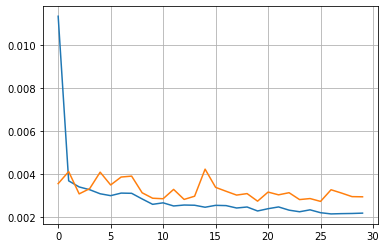


 14%|████████████                                                                        | 1/7 [00:08<00:50,  8.46s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_566"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_189 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1128 (Dense)             (None, 42)           1806        ['input_189[0][0]']              
                                                                                                  
 multiply_188 (Multiply)        (None, 42)           0           ['input_189[0][0]',              
                                                                  'dense_1128[0][0]']             
                                                                             

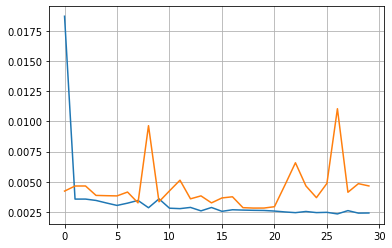


 29%|████████████████████████                                                            | 2/7 [00:17<00:44,  8.82s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_569"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_190 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1134 (Dense)             (None, 42)           1806        ['input_190[0][0]']              
                                                                                                  
 multiply_189 (Multiply)        (None, 42)           0           ['input_190[0][0]',              
                                                                  'dense_1134[0][0]']             
                                                                             

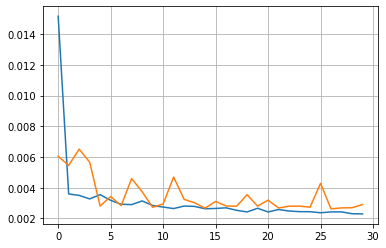


 43%|████████████████████████████████████                                                | 3/7 [00:25<00:33,  8.31s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_572"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_191 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1140 (Dense)             (None, 42)           1806        ['input_191[0][0]']              
                                                                                                  
 multiply_190 (Multiply)        (None, 42)           0           ['input_191[0][0]',              
                                                                  'dense_1140[0][0]']             
                                                                             

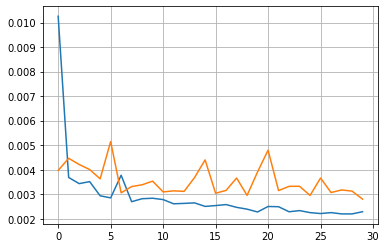


 57%|████████████████████████████████████████████████                                    | 4/7 [00:33<00:25,  8.40s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_575"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_192 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1146 (Dense)             (None, 42)           1806        ['input_192[0][0]']              
                                                                                                  
 multiply_191 (Multiply)        (None, 42)           0           ['input_192[0][0]',              
                                                                  'dense_1146[0][0]']             
                                                                             

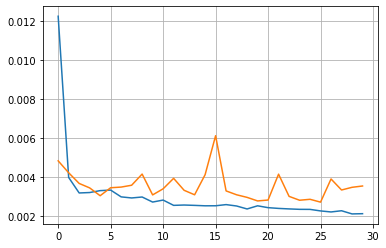


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:42<00:17,  8.56s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_578"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_193 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1152 (Dense)             (None, 42)           1806        ['input_193[0][0]']              
                                                                                                  
 multiply_192 (Multiply)        (None, 42)           0           ['input_193[0][0]',              
                                                                  'dense_1152[0][0]']             
                                                                             

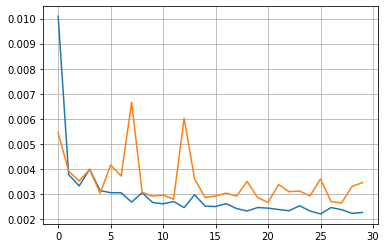


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:52<00:08,  8.84s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_581"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_194 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1158 (Dense)             (None, 42)           1806        ['input_194[0][0]']              
                                                                                                  
 multiply_193 (Multiply)        (None, 42)           0           ['input_194[0][0]',              
                                                                  'dense_1158[0][0]']             
                                                                             

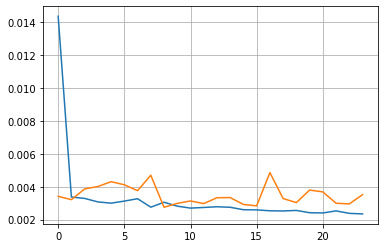


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_584"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_195 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1164 (Dense)             (None, 42)           1806        ['input_195[0][0]']              
                                                                                                  
 multiply_194 (Multiply)        (None, 42)           0           ['input_195[0][0]',              
                                                                  'dense_1164[0][0]']             
                                                                             

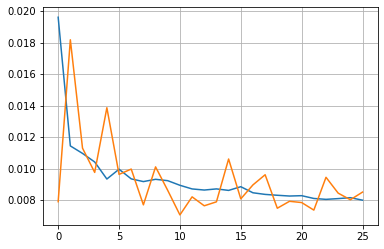


 14%|████████████                                                                        | 1/7 [00:05<00:32,  5.39s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_587"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_196 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1170 (Dense)             (None, 42)           1806        ['input_196[0][0]']              
                                                                                                  
 multiply_195 (Multiply)        (None, 42)           0           ['input_196[0][0]',              
                                                                  'dense_1170[0][0]']             
                                                                             

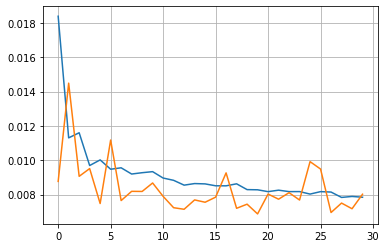


 29%|████████████████████████                                                            | 2/7 [00:12<00:32,  6.57s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_590"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_197 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1176 (Dense)             (None, 42)           1806        ['input_197[0][0]']              
                                                                                                  
 multiply_196 (Multiply)        (None, 42)           0           ['input_197[0][0]',              
                                                                  'dense_1176[0][0]']             
                                                                             

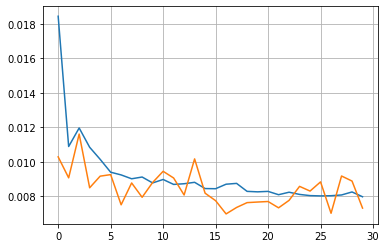


 43%|████████████████████████████████████                                                | 3/7 [00:20<00:28,  7.13s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_593"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_198 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1182 (Dense)             (None, 42)           1806        ['input_198[0][0]']              
                                                                                                  
 multiply_197 (Multiply)        (None, 42)           0           ['input_198[0][0]',              
                                                                  'dense_1182[0][0]']             
                                                                             

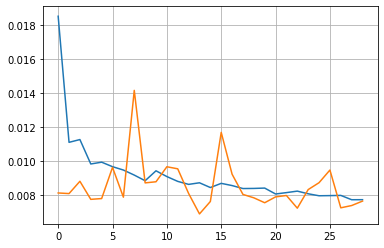


 57%|████████████████████████████████████████████████                                    | 4/7 [00:27<00:21,  7.06s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_596"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_199 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1188 (Dense)             (None, 42)           1806        ['input_199[0][0]']              
                                                                                                  
 multiply_198 (Multiply)        (None, 42)           0           ['input_199[0][0]',              
                                                                  'dense_1188[0][0]']             
                                                                             

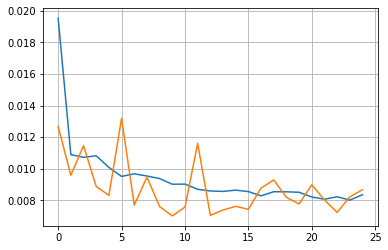


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:35<00:14,  7.49s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_599"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_200 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1194 (Dense)             (None, 42)           1806        ['input_200[0][0]']              
                                                                                                  
 multiply_199 (Multiply)        (None, 42)           0           ['input_200[0][0]',              
                                                                  'dense_1194[0][0]']             
                                                                             

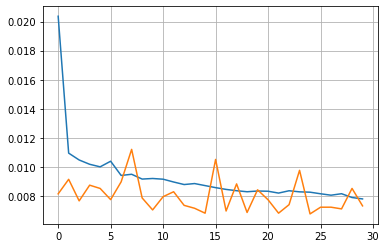


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:43<00:07,  7.43s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_602"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_201 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1200 (Dense)             (None, 42)           1806        ['input_201[0][0]']              
                                                                                                  
 multiply_200 (Multiply)        (None, 42)           0           ['input_201[0][0]',              
                                                                  'dense_1200[0][0]']             
                                                                             

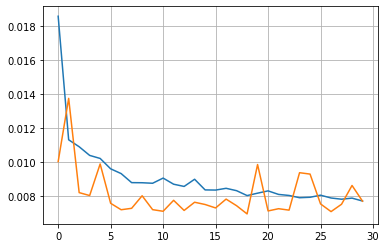


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_605"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_202 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1206 (Dense)             (None, 42)           1806        ['input_202[0][0]']              
                                                                                                  
 multiply_201 (Multiply)        (None, 42)           0           ['input_202[0][0]',              
                                                                  'dense_1206[0][0]']             
                                                                             

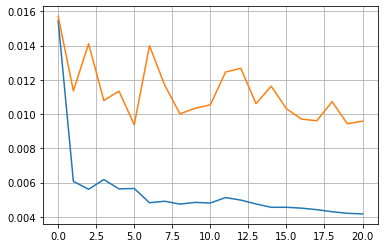


 14%|████████████                                                                        | 1/7 [00:05<00:35,  5.91s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_608"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_203 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1212 (Dense)             (None, 42)           1806        ['input_203[0][0]']              
                                                                                                  
 multiply_202 (Multiply)        (None, 42)           0           ['input_203[0][0]',              
                                                                  'dense_1212[0][0]']             
                                                                             

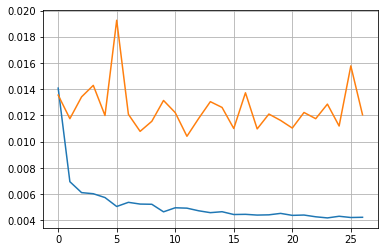


 29%|████████████████████████                                                            | 2/7 [00:12<00:32,  6.44s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_611"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_204 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1218 (Dense)             (None, 42)           1806        ['input_204[0][0]']              
                                                                                                  
 multiply_203 (Multiply)        (None, 42)           0           ['input_204[0][0]',              
                                                                  'dense_1218[0][0]']             
                                                                             

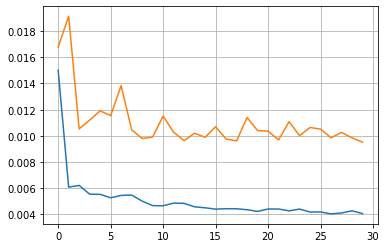


 43%|████████████████████████████████████                                                | 3/7 [00:21<00:30,  7.66s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_614"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_205 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1224 (Dense)             (None, 42)           1806        ['input_205[0][0]']              
                                                                                                  
 multiply_204 (Multiply)        (None, 42)           0           ['input_205[0][0]',              
                                                                  'dense_1224[0][0]']             
                                                                             

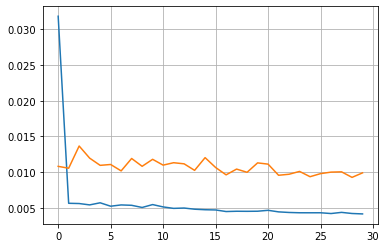


 57%|████████████████████████████████████████████████                                    | 4/7 [00:30<00:23,  7.96s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_617"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_206 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1230 (Dense)             (None, 42)           1806        ['input_206[0][0]']              
                                                                                                  
 multiply_205 (Multiply)        (None, 42)           0           ['input_206[0][0]',              
                                                                  'dense_1230[0][0]']             
                                                                             

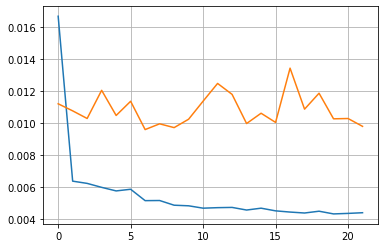


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:36<00:14,  7.22s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_620"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_207 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1236 (Dense)             (None, 42)           1806        ['input_207[0][0]']              
                                                                                                  
 multiply_206 (Multiply)        (None, 42)           0           ['input_207[0][0]',              
                                                                  'dense_1236[0][0]']             
                                                                             

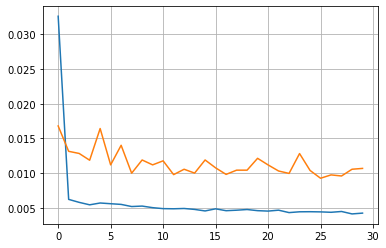


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:45<00:07,  7.78s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_623"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_208 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1242 (Dense)             (None, 42)           1806        ['input_208[0][0]']              
                                                                                                  
 multiply_207 (Multiply)        (None, 42)           0           ['input_208[0][0]',              
                                                                  'dense_1242[0][0]']             
                                                                             

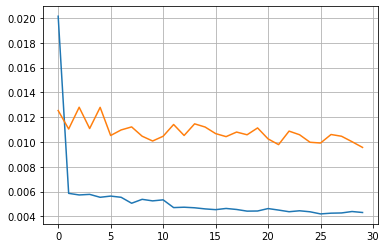


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_626"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_209 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1248 (Dense)             (None, 42)           1806        ['input_209[0][0]']              
                                                                                                  
 multiply_208 (Multiply)        (None, 42)           0           ['input_209[0][0]',              
                                                                  'dense_1248[0][0]']             
                                                                             

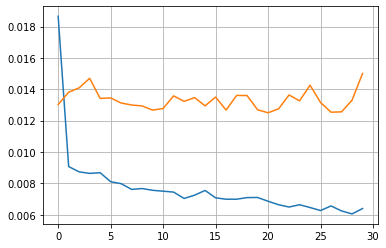


 14%|████████████                                                                        | 1/7 [00:07<00:42,  7.16s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_629"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_210 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1254 (Dense)             (None, 42)           1806        ['input_210[0][0]']              
                                                                                                  
 multiply_209 (Multiply)        (None, 42)           0           ['input_210[0][0]',              
                                                                  'dense_1254[0][0]']             
                                                                             

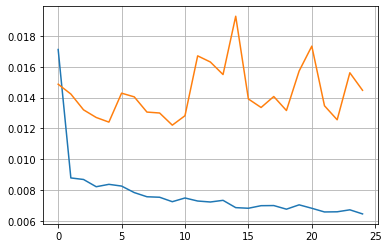


 29%|████████████████████████                                                            | 2/7 [00:14<00:35,  7.20s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_632"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_211 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1260 (Dense)             (None, 42)           1806        ['input_211[0][0]']              
                                                                                                  
 multiply_210 (Multiply)        (None, 42)           0           ['input_211[0][0]',              
                                                                  'dense_1260[0][0]']             
                                                                             

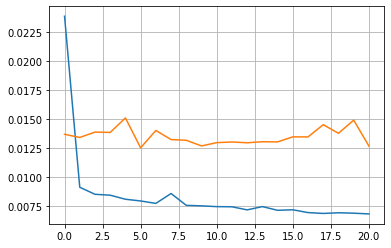


 43%|████████████████████████████████████                                                | 3/7 [00:19<00:24,  6.22s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_635"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_212 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1266 (Dense)             (None, 42)           1806        ['input_212[0][0]']              
                                                                                                  
 multiply_211 (Multiply)        (None, 42)           0           ['input_212[0][0]',              
                                                                  'dense_1266[0][0]']             
                                                                             

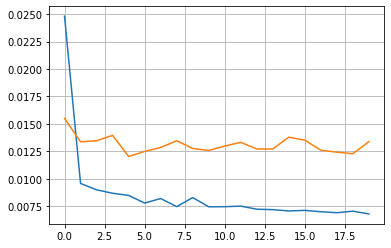


 57%|████████████████████████████████████████████████                                    | 4/7 [00:24<00:17,  5.75s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_638"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_213 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1272 (Dense)             (None, 42)           1806        ['input_213[0][0]']              
                                                                                                  
 multiply_212 (Multiply)        (None, 42)           0           ['input_213[0][0]',              
                                                                  'dense_1272[0][0]']             
                                                                             

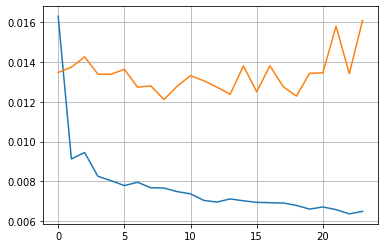


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:31<00:12,  6.05s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_641"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_214 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1278 (Dense)             (None, 42)           1806        ['input_214[0][0]']              
                                                                                                  
 multiply_213 (Multiply)        (None, 42)           0           ['input_214[0][0]',              
                                                                  'dense_1278[0][0]']             
                                                                             

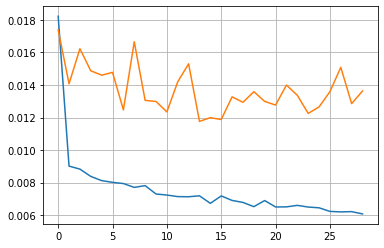


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:38<00:06,  6.45s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_644"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_215 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1284 (Dense)             (None, 42)           1806        ['input_215[0][0]']              
                                                                                                  
 multiply_214 (Multiply)        (None, 42)           0           ['input_215[0][0]',              
                                                                  'dense_1284[0][0]']             
                                                                             

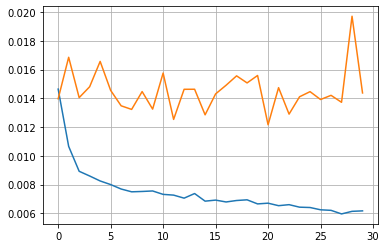


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_647"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_216 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1290 (Dense)             (None, 42)           1806        ['input_216[0][0]']              
                                                                                                  
 multiply_215 (Multiply)        (None, 42)           0           ['input_216[0][0]',              
                                                                  'dense_1290[0][0]']             
                                                                             

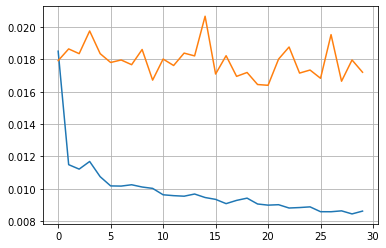


 14%|████████████                                                                        | 1/7 [00:07<00:46,  7.77s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_650"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_217 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1296 (Dense)             (None, 42)           1806        ['input_217[0][0]']              
                                                                                                  
 multiply_216 (Multiply)        (None, 42)           0           ['input_217[0][0]',              
                                                                  'dense_1296[0][0]']             
                                                                             

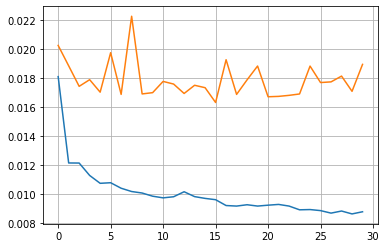


 29%|████████████████████████                                                            | 2/7 [00:15<00:38,  7.78s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_653"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_218 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1302 (Dense)             (None, 42)           1806        ['input_218[0][0]']              
                                                                                                  
 multiply_217 (Multiply)        (None, 42)           0           ['input_218[0][0]',              
                                                                  'dense_1302[0][0]']             
                                                                             

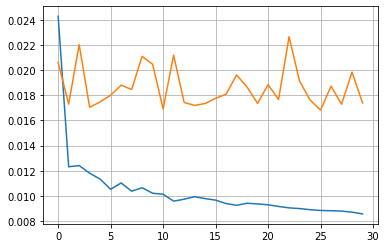


 43%|████████████████████████████████████                                                | 3/7 [00:22<00:30,  7.51s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_656"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_219 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1308 (Dense)             (None, 42)           1806        ['input_219[0][0]']              
                                                                                                  
 multiply_218 (Multiply)        (None, 42)           0           ['input_219[0][0]',              
                                                                  'dense_1308[0][0]']             
                                                                             

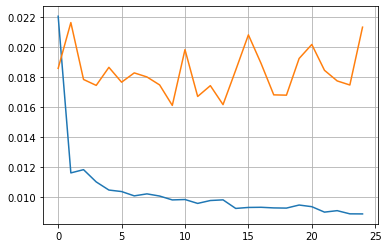


 57%|████████████████████████████████████████████████                                    | 4/7 [00:28<00:21,  7.01s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_659"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_220 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1314 (Dense)             (None, 42)           1806        ['input_220[0][0]']              
                                                                                                  
 multiply_219 (Multiply)        (None, 42)           0           ['input_220[0][0]',              
                                                                  'dense_1314[0][0]']             
                                                                             

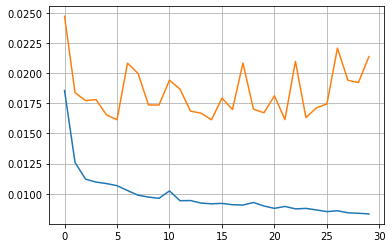


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:36<00:14,  7.27s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_662"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_221 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1320 (Dense)             (None, 42)           1806        ['input_221[0][0]']              
                                                                                                  
 multiply_220 (Multiply)        (None, 42)           0           ['input_221[0][0]',              
                                                                  'dense_1320[0][0]']             
                                                                             

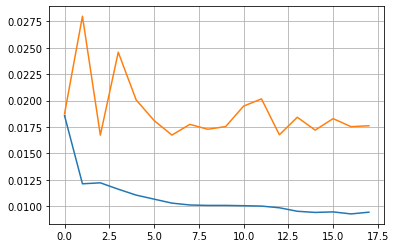


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:41<00:06,  6.27s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_665"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_222 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1326 (Dense)             (None, 42)           1806        ['input_222[0][0]']              
                                                                                                  
 multiply_221 (Multiply)        (None, 42)           0           ['input_222[0][0]',              
                                                                  'dense_1326[0][0]']             
                                                                             

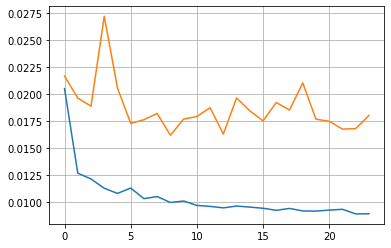


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_668"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_223 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1332 (Dense)             (None, 42)           1806        ['input_223[0][0]']              
                                                                                                  
 multiply_222 (Multiply)        (None, 42)           0           ['input_223[0][0]',              
                                                                  'dense_1332[0][0]']             
                                                                             

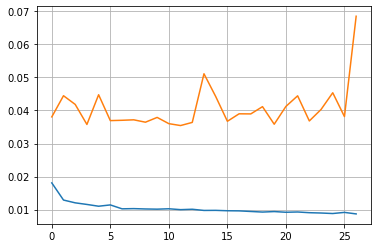


 14%|████████████                                                                        | 1/7 [00:05<00:34,  5.77s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_671"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_224 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1338 (Dense)             (None, 42)           1806        ['input_224[0][0]']              
                                                                                                  
 multiply_223 (Multiply)        (None, 42)           0           ['input_224[0][0]',              
                                                                  'dense_1338[0][0]']             
                                                                             

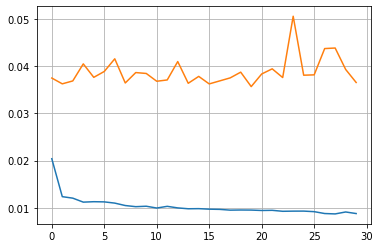


 29%|████████████████████████                                                            | 2/7 [00:12<00:31,  6.25s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_674"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_225 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1344 (Dense)             (None, 42)           1806        ['input_225[0][0]']              
                                                                                                  
 multiply_224 (Multiply)        (None, 42)           0           ['input_225[0][0]',              
                                                                  'dense_1344[0][0]']             
                                                                             

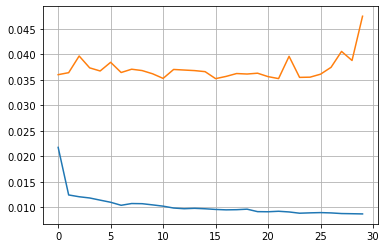


 43%|████████████████████████████████████                                                | 3/7 [00:18<00:24,  6.10s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_677"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_226 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1350 (Dense)             (None, 42)           1806        ['input_226[0][0]']              
                                                                                                  
 multiply_225 (Multiply)        (None, 42)           0           ['input_226[0][0]',              
                                                                  'dense_1350[0][0]']             
                                                                             

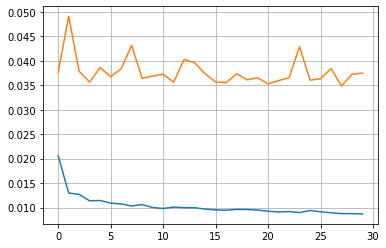


 57%|████████████████████████████████████████████████                                    | 4/7 [00:25<00:20,  6.74s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_680"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_227 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1356 (Dense)             (None, 42)           1806        ['input_227[0][0]']              
                                                                                                  
 multiply_226 (Multiply)        (None, 42)           0           ['input_227[0][0]',              
                                                                  'dense_1356[0][0]']             
                                                                             

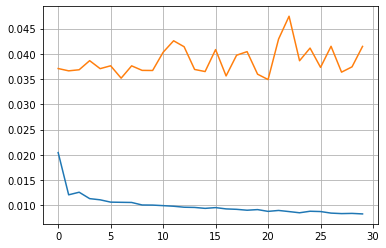


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:32<00:13,  6.71s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_683"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_228 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1362 (Dense)             (None, 42)           1806        ['input_228[0][0]']              
                                                                                                  
 multiply_227 (Multiply)        (None, 42)           0           ['input_228[0][0]',              
                                                                  'dense_1362[0][0]']             
                                                                             

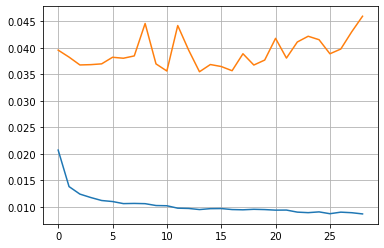


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:39<00:06,  6.85s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_686"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_229 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1368 (Dense)             (None, 42)           1806        ['input_229[0][0]']              
                                                                                                  
 multiply_228 (Multiply)        (None, 42)           0           ['input_229[0][0]',              
                                                                  'dense_1368[0][0]']             
                                                                             

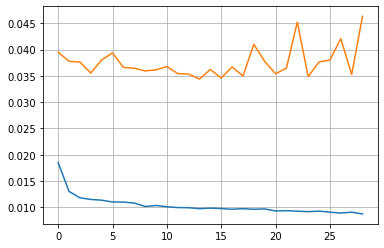


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_689"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_230 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1374 (Dense)             (None, 42)           1806        ['input_230[0][0]']              
                                                                                                  
 multiply_229 (Multiply)        (None, 42)           0           ['input_230[0][0]',              
                                                                  'dense_1374[0][0]']             
                                                                             

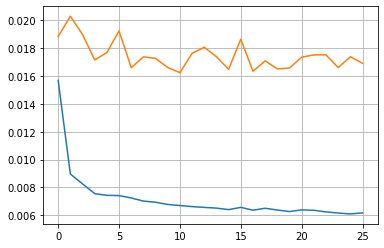


 14%|████████████                                                                        | 1/7 [00:06<00:37,  6.19s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_692"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_231 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1380 (Dense)             (None, 42)           1806        ['input_231[0][0]']              
                                                                                                  
 multiply_230 (Multiply)        (None, 42)           0           ['input_231[0][0]',              
                                                                  'dense_1380[0][0]']             
                                                                             

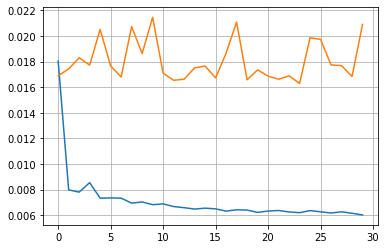


 29%|████████████████████████                                                            | 2/7 [00:12<00:32,  6.44s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_695"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_232 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1386 (Dense)             (None, 42)           1806        ['input_232[0][0]']              
                                                                                                  
 multiply_231 (Multiply)        (None, 42)           0           ['input_232[0][0]',              
                                                                  'dense_1386[0][0]']             
                                                                             

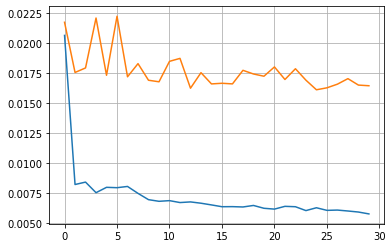


 43%|████████████████████████████████████                                                | 3/7 [00:21<00:30,  7.54s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_698"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_233 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1392 (Dense)             (None, 42)           1806        ['input_233[0][0]']              
                                                                                                  
 multiply_232 (Multiply)        (None, 42)           0           ['input_233[0][0]',              
                                                                  'dense_1392[0][0]']             
                                                                             

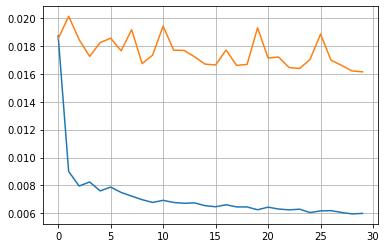


 57%|████████████████████████████████████████████████                                    | 4/7 [00:32<00:26,  8.81s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_701"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_234 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1398 (Dense)             (None, 42)           1806        ['input_234[0][0]']              
                                                                                                  
 multiply_233 (Multiply)        (None, 42)           0           ['input_234[0][0]',              
                                                                  'dense_1398[0][0]']             
                                                                             

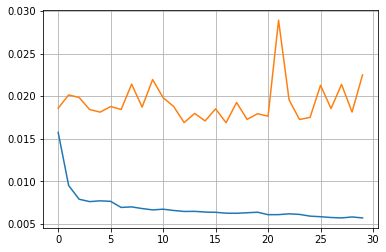


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:39<00:16,  8.23s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_704"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_235 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1404 (Dense)             (None, 42)           1806        ['input_235[0][0]']              
                                                                                                  
 multiply_234 (Multiply)        (None, 42)           0           ['input_235[0][0]',              
                                                                  'dense_1404[0][0]']             
                                                                             

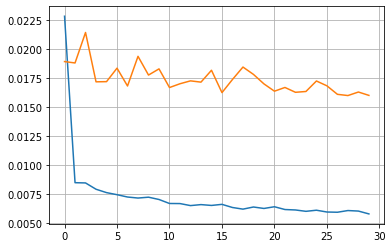


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:48<00:08,  8.53s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_707"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_236 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1410 (Dense)             (None, 42)           1806        ['input_236[0][0]']              
                                                                                                  
 multiply_235 (Multiply)        (None, 42)           0           ['input_236[0][0]',              
                                                                  'dense_1410[0][0]']             
                                                                             

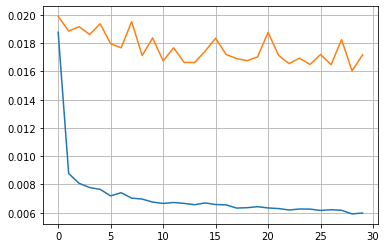


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_710"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_237 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1416 (Dense)             (None, 42)           1806        ['input_237[0][0]']              
                                                                                                  
 multiply_236 (Multiply)        (None, 42)           0           ['input_237[0][0]',              
                                                                  'dense_1416[0][0]']             
                                                                             

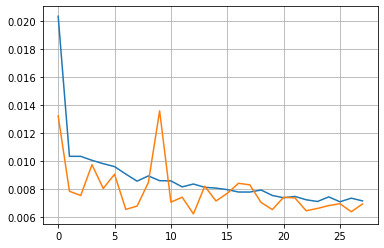


 14%|████████████                                                                        | 1/7 [00:07<00:42,  7.08s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_713"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_238 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1422 (Dense)             (None, 42)           1806        ['input_238[0][0]']              
                                                                                                  
 multiply_237 (Multiply)        (None, 42)           0           ['input_238[0][0]',              
                                                                  'dense_1422[0][0]']             
                                                                             

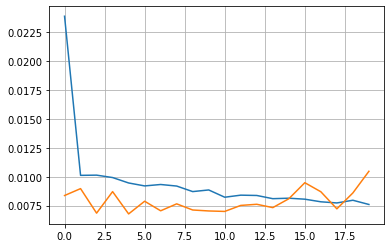


 29%|████████████████████████                                                            | 2/7 [00:12<00:29,  5.89s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_716"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_239 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1428 (Dense)             (None, 42)           1806        ['input_239[0][0]']              
                                                                                                  
 multiply_238 (Multiply)        (None, 42)           0           ['input_239[0][0]',              
                                                                  'dense_1428[0][0]']             
                                                                             

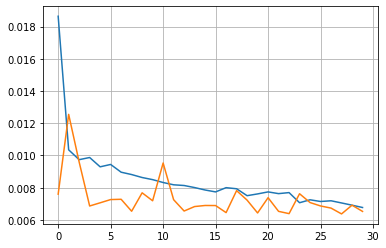


 43%|████████████████████████████████████                                                | 3/7 [00:20<00:27,  6.95s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_719"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_240 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1434 (Dense)             (None, 42)           1806        ['input_240[0][0]']              
                                                                                                  
 multiply_239 (Multiply)        (None, 42)           0           ['input_240[0][0]',              
                                                                  'dense_1434[0][0]']             
                                                                             

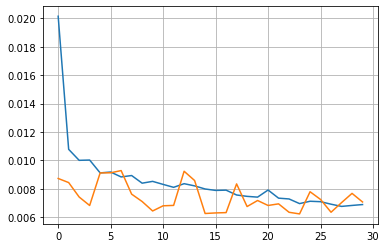


 57%|████████████████████████████████████████████████                                    | 4/7 [00:28<00:22,  7.44s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_722"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_241 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1440 (Dense)             (None, 42)           1806        ['input_241[0][0]']              
                                                                                                  
 multiply_240 (Multiply)        (None, 42)           0           ['input_241[0][0]',              
                                                                  'dense_1440[0][0]']             
                                                                             

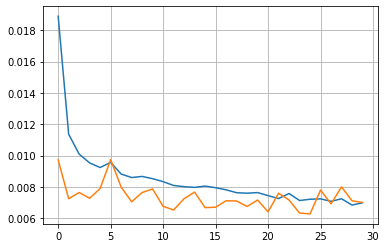


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:37<00:15,  7.90s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_725"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_242 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1446 (Dense)             (None, 42)           1806        ['input_242[0][0]']              
                                                                                                  
 multiply_241 (Multiply)        (None, 42)           0           ['input_242[0][0]',              
                                                                  'dense_1446[0][0]']             
                                                                             

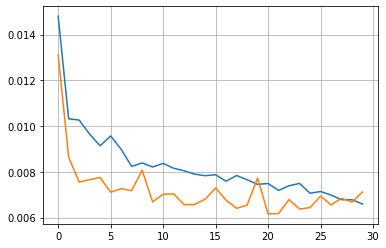


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:46<00:08,  8.28s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_728"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_243 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1452 (Dense)             (None, 42)           1806        ['input_243[0][0]']              
                                                                                                  
 multiply_242 (Multiply)        (None, 42)           0           ['input_243[0][0]',              
                                                                  'dense_1452[0][0]']             
                                                                             

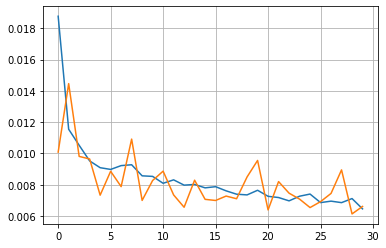


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_731"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_244 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1458 (Dense)             (None, 42)           1806        ['input_244[0][0]']              
                                                                                                  
 multiply_243 (Multiply)        (None, 42)           0           ['input_244[0][0]',              
                                                                  'dense_1458[0][0]']             
                                                                             

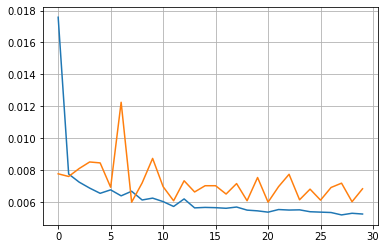


 14%|████████████                                                                        | 1/7 [00:07<00:42,  7.01s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_734"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_245 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1464 (Dense)             (None, 42)           1806        ['input_245[0][0]']              
                                                                                                  
 multiply_244 (Multiply)        (None, 42)           0           ['input_245[0][0]',              
                                                                  'dense_1464[0][0]']             
                                                                             

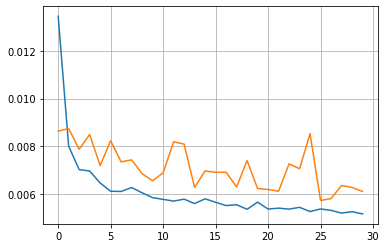


 29%|████████████████████████                                                            | 2/7 [00:17<00:44,  8.88s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_737"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_246 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1470 (Dense)             (None, 42)           1806        ['input_246[0][0]']              
                                                                                                  
 multiply_245 (Multiply)        (None, 42)           0           ['input_246[0][0]',              
                                                                  'dense_1470[0][0]']             
                                                                             

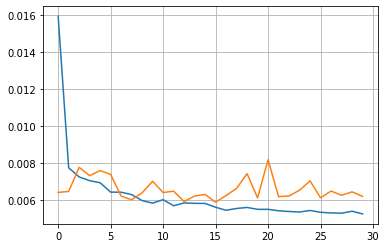


 43%|████████████████████████████████████                                                | 3/7 [00:24<00:32,  8.11s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_740"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_247 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1476 (Dense)             (None, 42)           1806        ['input_247[0][0]']              
                                                                                                  
 multiply_246 (Multiply)        (None, 42)           0           ['input_247[0][0]',              
                                                                  'dense_1476[0][0]']             
                                                                             

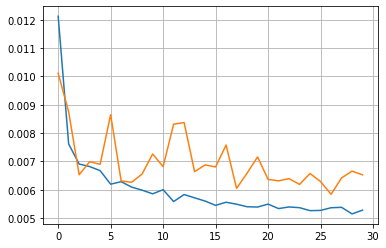


 57%|████████████████████████████████████████████████                                    | 4/7 [00:32<00:24,  8.22s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_743"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_248 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1482 (Dense)             (None, 42)           1806        ['input_248[0][0]']              
                                                                                                  
 multiply_247 (Multiply)        (None, 42)           0           ['input_248[0][0]',              
                                                                  'dense_1482[0][0]']             
                                                                             

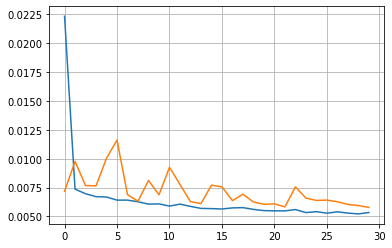


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:41<00:17,  8.50s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_746"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_249 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1488 (Dense)             (None, 42)           1806        ['input_249[0][0]']              
                                                                                                  
 multiply_248 (Multiply)        (None, 42)           0           ['input_249[0][0]',              
                                                                  'dense_1488[0][0]']             
                                                                             

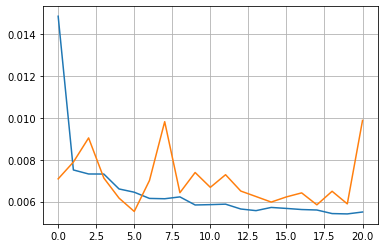


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:46<00:07,  7.35s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_749"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_250 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1494 (Dense)             (None, 42)           1806        ['input_250[0][0]']              
                                                                                                  
 multiply_249 (Multiply)        (None, 42)           0           ['input_250[0][0]',              
                                                                  'dense_1494[0][0]']             
                                                                             

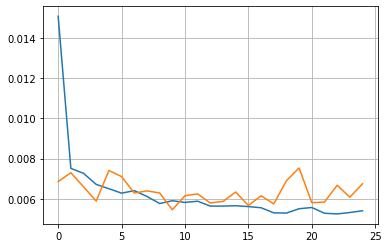


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_752"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_251 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1500 (Dense)             (None, 42)           1806        ['input_251[0][0]']              
                                                                                                  
 multiply_250 (Multiply)        (None, 42)           0           ['input_251[0][0]',              
                                                                  'dense_1500[0][0]']             
                                                                             

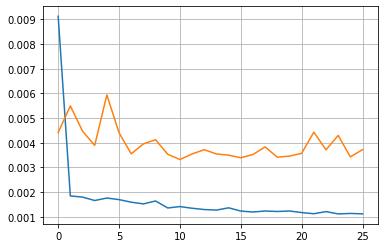


 14%|████████████                                                                        | 1/7 [00:06<00:40,  6.74s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_755"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_252 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1506 (Dense)             (None, 42)           1806        ['input_252[0][0]']              
                                                                                                  
 multiply_251 (Multiply)        (None, 42)           0           ['input_252[0][0]',              
                                                                  'dense_1506[0][0]']             
                                                                             

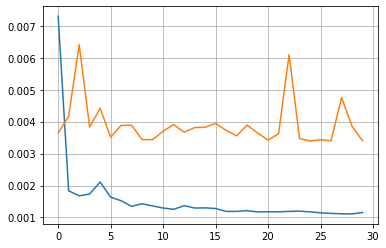


 29%|████████████████████████                                                            | 2/7 [00:13<00:34,  6.96s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_758"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_253 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1512 (Dense)             (None, 42)           1806        ['input_253[0][0]']              
                                                                                                  
 multiply_252 (Multiply)        (None, 42)           0           ['input_253[0][0]',              
                                                                  'dense_1512[0][0]']             
                                                                             

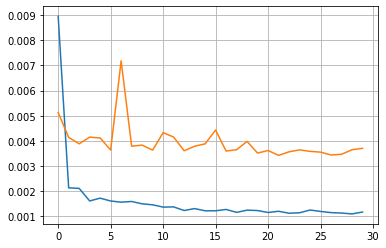


 43%|████████████████████████████████████                                                | 3/7 [00:23<00:32,  8.11s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_761"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_254 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1518 (Dense)             (None, 42)           1806        ['input_254[0][0]']              
                                                                                                  
 multiply_253 (Multiply)        (None, 42)           0           ['input_254[0][0]',              
                                                                  'dense_1518[0][0]']             
                                                                             

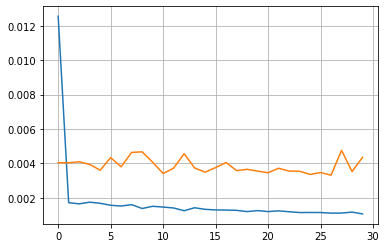


 57%|████████████████████████████████████████████████                                    | 4/7 [00:31<00:24,  8.13s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_764"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_255 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1524 (Dense)             (None, 42)           1806        ['input_255[0][0]']              
                                                                                                  
 multiply_254 (Multiply)        (None, 42)           0           ['input_255[0][0]',              
                                                                  'dense_1524[0][0]']             
                                                                             

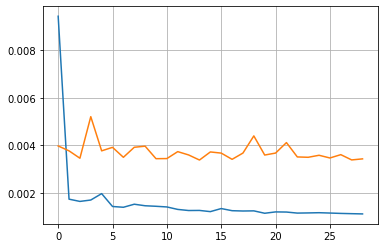


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:38<00:15,  7.73s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_767"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_256 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1530 (Dense)             (None, 42)           1806        ['input_256[0][0]']              
                                                                                                  
 multiply_255 (Multiply)        (None, 42)           0           ['input_256[0][0]',              
                                                                  'dense_1530[0][0]']             
                                                                             

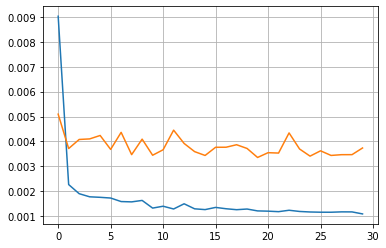


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:46<00:07,  7.87s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_770"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_257 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1536 (Dense)             (None, 42)           1806        ['input_257[0][0]']              
                                                                                                  
 multiply_256 (Multiply)        (None, 42)           0           ['input_257[0][0]',              
                                                                  'dense_1536[0][0]']             
                                                                             

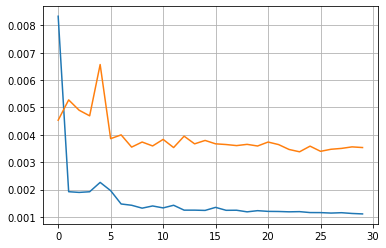


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (2635, 39) Test_size: (1, 39)
X_train: (2635, 38) Y_train: (2635, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_773"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_258 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_1542 (Dense)             (None, 38)           1482        ['input_258[0][0]']              
                                                                                                  
 multiply_257 (Multiply)        (None, 38)           0           ['input_258[0][0]',              
                                                                  'dense_1542[0][0]']             
                                                                             

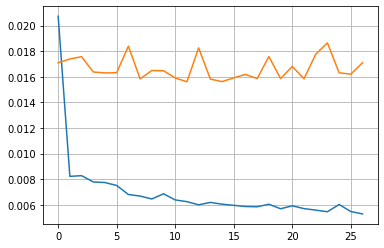


 14%|████████████                                                                        | 1/7 [00:05<00:34,  5.80s/it]

Train_size: (2636, 39) Test_size: (1, 39)
X_train: (2636, 38) Y_train: (2636, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_776"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_259 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_1548 (Dense)             (None, 38)           1482        ['input_259[0][0]']              
                                                                                                  
 multiply_258 (Multiply)        (None, 38)           0           ['input_259[0][0]',              
                                                                  'dense_1548[0][0]']             
                                                                             

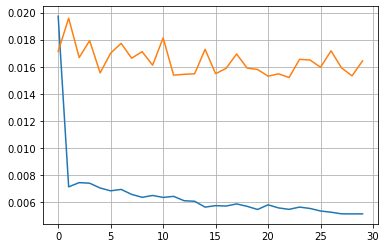


 29%|████████████████████████                                                            | 2/7 [00:12<00:30,  6.16s/it]

Train_size: (2637, 39) Test_size: (1, 39)
X_train: (2637, 38) Y_train: (2637, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_779"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_260 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_1554 (Dense)             (None, 38)           1482        ['input_260[0][0]']              
                                                                                                  
 multiply_259 (Multiply)        (None, 38)           0           ['input_260[0][0]',              
                                                                  'dense_1554[0][0]']             
                                                                             

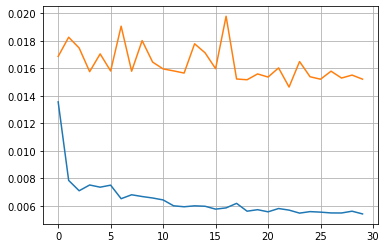


 43%|████████████████████████████████████                                                | 3/7 [00:18<00:25,  6.27s/it]

Train_size: (2638, 39) Test_size: (1, 39)
X_train: (2638, 38) Y_train: (2638, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_782"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_261 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_1560 (Dense)             (None, 38)           1482        ['input_261[0][0]']              
                                                                                                  
 multiply_260 (Multiply)        (None, 38)           0           ['input_261[0][0]',              
                                                                  'dense_1560[0][0]']             
                                                                             

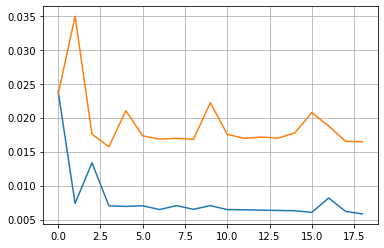


 57%|████████████████████████████████████████████████                                    | 4/7 [00:22<00:16,  5.40s/it]

Train_size: (2639, 39) Test_size: (1, 39)
X_train: (2639, 38) Y_train: (2639, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_785"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_262 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_1566 (Dense)             (None, 38)           1482        ['input_262[0][0]']              
                                                                                                  
 multiply_261 (Multiply)        (None, 38)           0           ['input_262[0][0]',              
                                                                  'dense_1566[0][0]']             
                                                                             

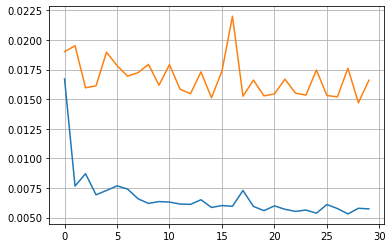


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:29<00:11,  5.79s/it]

Train_size: (2640, 39) Test_size: (1, 39)
X_train: (2640, 38) Y_train: (2640, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_788"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_263 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_1572 (Dense)             (None, 38)           1482        ['input_263[0][0]']              
                                                                                                  
 multiply_262 (Multiply)        (None, 38)           0           ['input_263[0][0]',              
                                                                  'dense_1572[0][0]']             
                                                                             

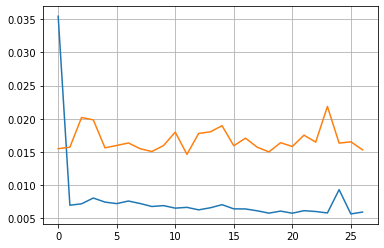


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:34<00:05,  5.58s/it]

Train_size: (2641, 39) Test_size: (1, 39)
X_train: (2641, 38) Y_train: (2641, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_791"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_264 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_1578 (Dense)             (None, 38)           1482        ['input_264[0][0]']              
                                                                                                  
 multiply_263 (Multiply)        (None, 38)           0           ['input_264[0][0]',              
                                                                  'dense_1578[0][0]']             
                                                                             

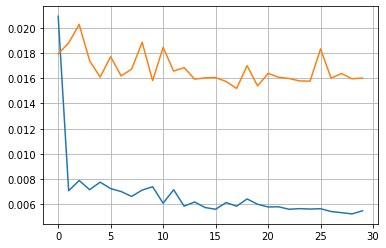


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_794"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_265 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1584 (Dense)             (None, 42)           1806        ['input_265[0][0]']              
                                                                                                  
 multiply_264 (Multiply)        (None, 42)           0           ['input_265[0][0]',              
                                                                  'dense_1584[0][0]']             
                                                                             

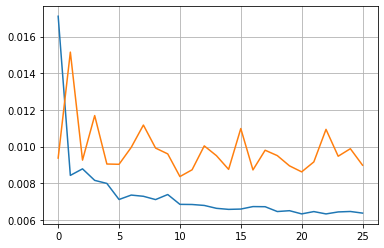


 14%|████████████                                                                        | 1/7 [00:06<00:40,  6.75s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_797"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_266 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1590 (Dense)             (None, 42)           1806        ['input_266[0][0]']              
                                                                                                  
 multiply_265 (Multiply)        (None, 42)           0           ['input_266[0][0]',              
                                                                  'dense_1590[0][0]']             
                                                                             

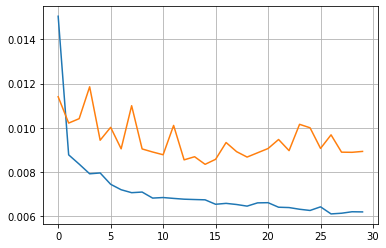


 29%|████████████████████████                                                            | 2/7 [00:16<00:41,  8.34s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_800"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_267 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1596 (Dense)             (None, 42)           1806        ['input_267[0][0]']              
                                                                                                  
 multiply_266 (Multiply)        (None, 42)           0           ['input_267[0][0]',              
                                                                  'dense_1596[0][0]']             
                                                                             

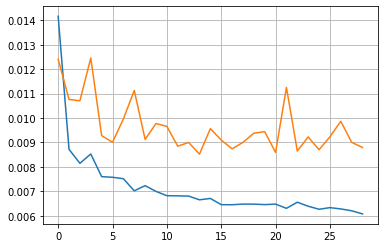


 43%|████████████████████████████████████                                                | 3/7 [00:24<00:32,  8.25s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_803"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_268 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1602 (Dense)             (None, 42)           1806        ['input_268[0][0]']              
                                                                                                  
 multiply_267 (Multiply)        (None, 42)           0           ['input_268[0][0]',              
                                                                  'dense_1602[0][0]']             
                                                                             

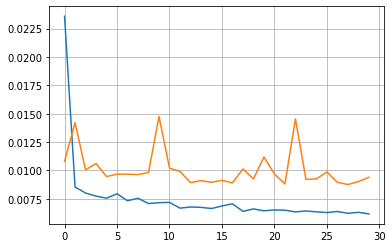


 57%|████████████████████████████████████████████████                                    | 4/7 [00:32<00:24,  8.31s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_806"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_269 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1608 (Dense)             (None, 42)           1806        ['input_269[0][0]']              
                                                                                                  
 multiply_268 (Multiply)        (None, 42)           0           ['input_269[0][0]',              
                                                                  'dense_1608[0][0]']             
                                                                             

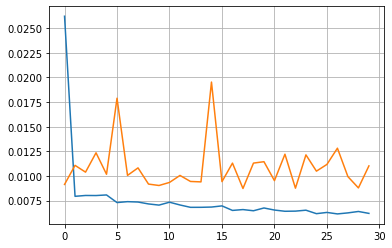


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:38<00:14,  7.42s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_809"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_270 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1614 (Dense)             (None, 42)           1806        ['input_270[0][0]']              
                                                                                                  
 multiply_269 (Multiply)        (None, 42)           0           ['input_270[0][0]',              
                                                                  'dense_1614[0][0]']             
                                                                             

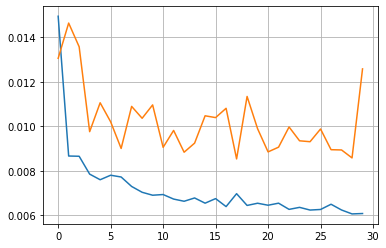


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:45<00:07,  7.29s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_812"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_271 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1620 (Dense)             (None, 42)           1806        ['input_271[0][0]']              
                                                                                                  
 multiply_270 (Multiply)        (None, 42)           0           ['input_271[0][0]',              
                                                                  'dense_1620[0][0]']             
                                                                             

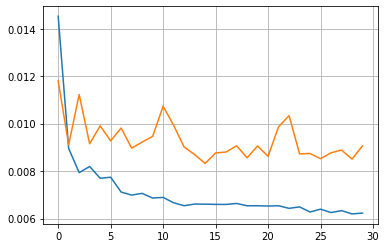


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_815"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_272 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1626 (Dense)             (None, 42)           1806        ['input_272[0][0]']              
                                                                                                  
 multiply_271 (Multiply)        (None, 42)           0           ['input_272[0][0]',              
                                                                  'dense_1626[0][0]']             
                                                                             

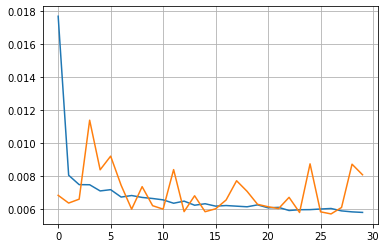


 14%|████████████                                                                        | 1/7 [00:08<00:49,  8.19s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_818"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_273 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1632 (Dense)             (None, 42)           1806        ['input_273[0][0]']              
                                                                                                  
 multiply_272 (Multiply)        (None, 42)           0           ['input_273[0][0]',              
                                                                  'dense_1632[0][0]']             
                                                                             

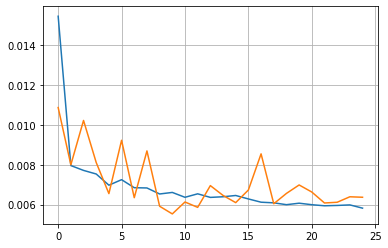


 29%|████████████████████████                                                            | 2/7 [00:15<00:38,  7.60s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_821"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_274 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1638 (Dense)             (None, 42)           1806        ['input_274[0][0]']              
                                                                                                  
 multiply_273 (Multiply)        (None, 42)           0           ['input_274[0][0]',              
                                                                  'dense_1638[0][0]']             
                                                                             

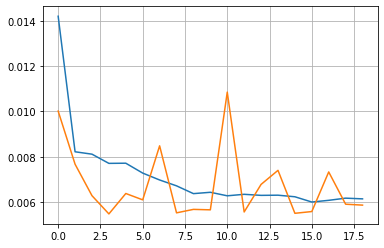


 43%|████████████████████████████████████                                                | 3/7 [00:20<00:26,  6.64s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_824"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_275 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1644 (Dense)             (None, 42)           1806        ['input_275[0][0]']              
                                                                                                  
 multiply_274 (Multiply)        (None, 42)           0           ['input_275[0][0]',              
                                                                  'dense_1644[0][0]']             
                                                                             

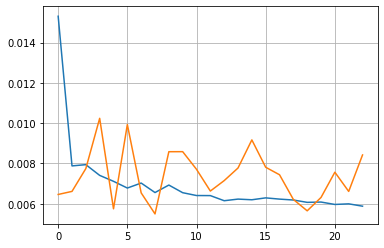


 57%|████████████████████████████████████████████████                                    | 4/7 [00:26<00:18,  6.11s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_827"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_276 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1650 (Dense)             (None, 42)           1806        ['input_276[0][0]']              
                                                                                                  
 multiply_275 (Multiply)        (None, 42)           0           ['input_276[0][0]',              
                                                                  'dense_1650[0][0]']             
                                                                             

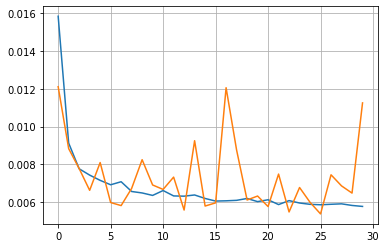


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:35<00:14,  7.26s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_830"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_277 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1656 (Dense)             (None, 42)           1806        ['input_277[0][0]']              
                                                                                                  
 multiply_276 (Multiply)        (None, 42)           0           ['input_277[0][0]',              
                                                                  'dense_1656[0][0]']             
                                                                             

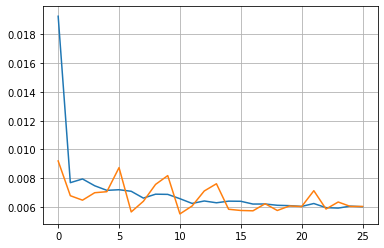


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:42<00:07,  7.10s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_833"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_278 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1662 (Dense)             (None, 42)           1806        ['input_278[0][0]']              
                                                                                                  
 multiply_277 (Multiply)        (None, 42)           0           ['input_278[0][0]',              
                                                                  'dense_1662[0][0]']             
                                                                             

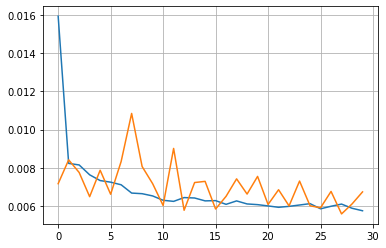


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_836"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_279 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1668 (Dense)             (None, 42)           1806        ['input_279[0][0]']              
                                                                                                  
 multiply_278 (Multiply)        (None, 42)           0           ['input_279[0][0]',              
                                                                  'dense_1668[0][0]']             
                                                                             

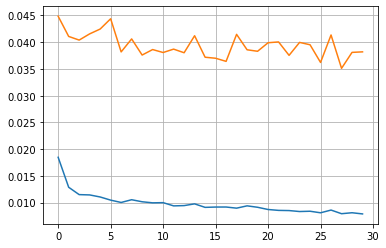


 14%|████████████                                                                        | 1/7 [00:10<01:00, 10.00s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_839"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_280 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1674 (Dense)             (None, 42)           1806        ['input_280[0][0]']              
                                                                                                  
 multiply_279 (Multiply)        (None, 42)           0           ['input_280[0][0]',              
                                                                  'dense_1674[0][0]']             
                                                                             

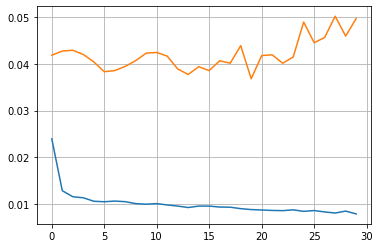


 29%|████████████████████████                                                            | 2/7 [00:17<00:41,  8.31s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_842"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_281 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1680 (Dense)             (None, 42)           1806        ['input_281[0][0]']              
                                                                                                  
 multiply_280 (Multiply)        (None, 42)           0           ['input_281[0][0]',              
                                                                  'dense_1680[0][0]']             
                                                                             

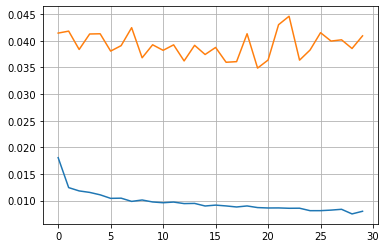


 43%|████████████████████████████████████                                                | 3/7 [00:25<00:33,  8.27s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_845"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_282 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1686 (Dense)             (None, 42)           1806        ['input_282[0][0]']              
                                                                                                  
 multiply_281 (Multiply)        (None, 42)           0           ['input_282[0][0]',              
                                                                  'dense_1686[0][0]']             
                                                                             

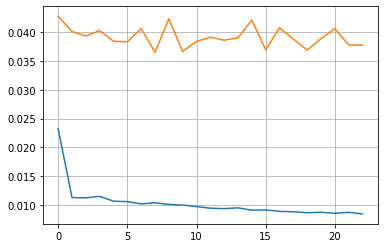


 57%|████████████████████████████████████████████████                                    | 4/7 [00:32<00:23,  7.79s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_848"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_283 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1692 (Dense)             (None, 42)           1806        ['input_283[0][0]']              
                                                                                                  
 multiply_282 (Multiply)        (None, 42)           0           ['input_283[0][0]',              
                                                                  'dense_1692[0][0]']             
                                                                             

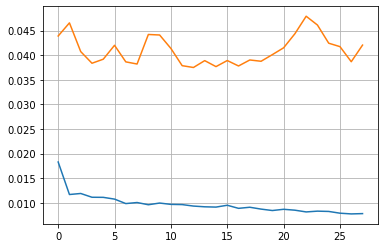


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:39<00:15,  7.65s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_851"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_284 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1698 (Dense)             (None, 42)           1806        ['input_284[0][0]']              
                                                                                                  
 multiply_283 (Multiply)        (None, 42)           0           ['input_284[0][0]',              
                                                                  'dense_1698[0][0]']             
                                                                             

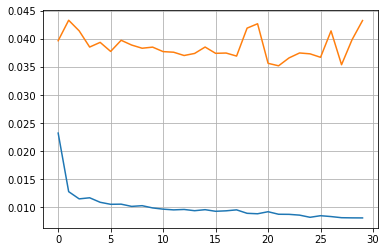


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:49<00:08,  8.23s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_854"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_285 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1704 (Dense)             (None, 42)           1806        ['input_285[0][0]']              
                                                                                                  
 multiply_284 (Multiply)        (None, 42)           0           ['input_285[0][0]',              
                                                                  'dense_1704[0][0]']             
                                                                             

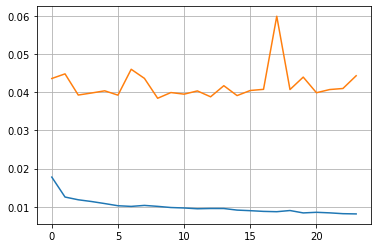


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_857"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_286 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1710 (Dense)             (None, 42)           1806        ['input_286[0][0]']              
                                                                                                  
 multiply_285 (Multiply)        (None, 42)           0           ['input_286[0][0]',              
                                                                  'dense_1710[0][0]']             
                                                                             

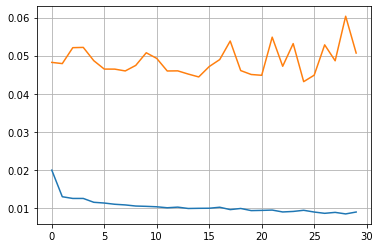


 14%|████████████                                                                        | 1/7 [00:09<00:56,  9.39s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_860"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_287 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1716 (Dense)             (None, 42)           1806        ['input_287[0][0]']              
                                                                                                  
 multiply_286 (Multiply)        (None, 42)           0           ['input_287[0][0]',              
                                                                  'dense_1716[0][0]']             
                                                                             

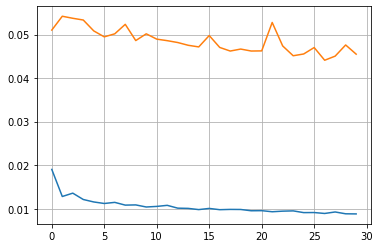


 29%|████████████████████████                                                            | 2/7 [00:20<00:52, 10.43s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_863"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_288 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1722 (Dense)             (None, 42)           1806        ['input_288[0][0]']              
                                                                                                  
 multiply_287 (Multiply)        (None, 42)           0           ['input_288[0][0]',              
                                                                  'dense_1722[0][0]']             
                                                                             

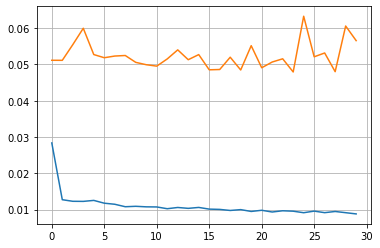


 43%|████████████████████████████████████                                                | 3/7 [00:29<00:38,  9.68s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_866"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_289 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1728 (Dense)             (None, 42)           1806        ['input_289[0][0]']              
                                                                                                  
 multiply_288 (Multiply)        (None, 42)           0           ['input_289[0][0]',              
                                                                  'dense_1728[0][0]']             
                                                                             

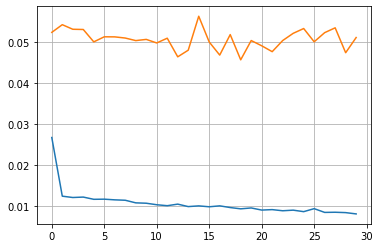


 57%|████████████████████████████████████████████████                                    | 4/7 [00:36<00:25,  8.62s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_869"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_290 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1734 (Dense)             (None, 42)           1806        ['input_290[0][0]']              
                                                                                                  
 multiply_289 (Multiply)        (None, 42)           0           ['input_290[0][0]',              
                                                                  'dense_1734[0][0]']             
                                                                             

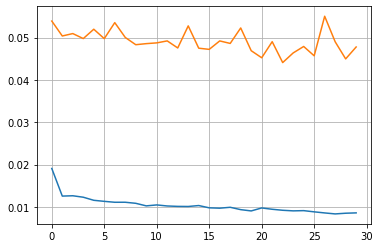


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:46<00:18,  9.28s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_872"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_291 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1740 (Dense)             (None, 42)           1806        ['input_291[0][0]']              
                                                                                                  
 multiply_290 (Multiply)        (None, 42)           0           ['input_291[0][0]',              
                                                                  'dense_1740[0][0]']             
                                                                             

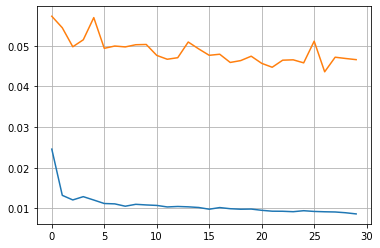


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:56<00:09,  9.43s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_875"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_292 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1746 (Dense)             (None, 42)           1806        ['input_292[0][0]']              
                                                                                                  
 multiply_291 (Multiply)        (None, 42)           0           ['input_292[0][0]',              
                                                                  'dense_1746[0][0]']             
                                                                             

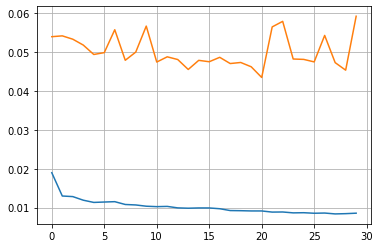


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_878"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_293 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1752 (Dense)             (None, 42)           1806        ['input_293[0][0]']              
                                                                                                  
 multiply_292 (Multiply)        (None, 42)           0           ['input_293[0][0]',              
                                                                  'dense_1752[0][0]']             
                                                                             

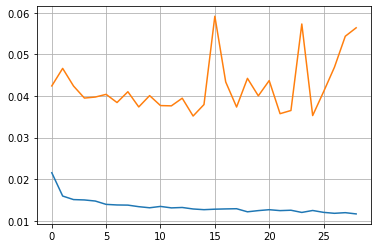


 14%|████████████                                                                        | 1/7 [00:07<00:44,  7.47s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_881"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_294 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1758 (Dense)             (None, 42)           1806        ['input_294[0][0]']              
                                                                                                  
 multiply_293 (Multiply)        (None, 42)           0           ['input_294[0][0]',              
                                                                  'dense_1758[0][0]']             
                                                                             

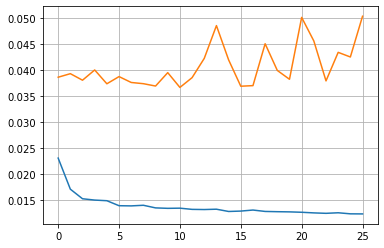


 29%|████████████████████████                                                            | 2/7 [00:14<00:34,  7.00s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_884"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_295 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1764 (Dense)             (None, 42)           1806        ['input_295[0][0]']              
                                                                                                  
 multiply_294 (Multiply)        (None, 42)           0           ['input_295[0][0]',              
                                                                  'dense_1764[0][0]']             
                                                                             

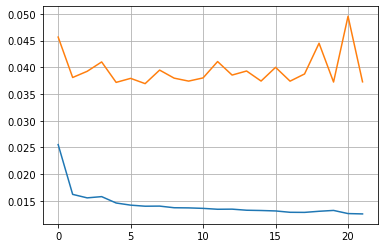


 43%|████████████████████████████████████                                                | 3/7 [00:19<00:25,  6.40s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_887"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_296 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1770 (Dense)             (None, 42)           1806        ['input_296[0][0]']              
                                                                                                  
 multiply_295 (Multiply)        (None, 42)           0           ['input_296[0][0]',              
                                                                  'dense_1770[0][0]']             
                                                                             

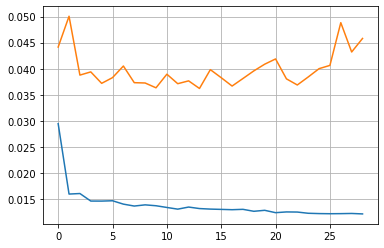


 57%|████████████████████████████████████████████████                                    | 4/7 [00:26<00:19,  6.57s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_890"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_297 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1776 (Dense)             (None, 42)           1806        ['input_297[0][0]']              
                                                                                                  
 multiply_296 (Multiply)        (None, 42)           0           ['input_297[0][0]',              
                                                                  'dense_1776[0][0]']             
                                                                             

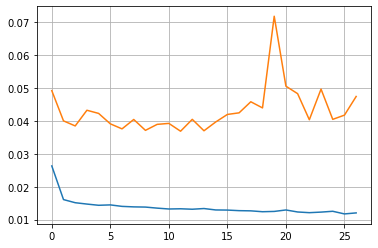


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:33<00:13,  6.82s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_893"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_298 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1782 (Dense)             (None, 42)           1806        ['input_298[0][0]']              
                                                                                                  
 multiply_297 (Multiply)        (None, 42)           0           ['input_298[0][0]',              
                                                                  'dense_1782[0][0]']             
                                                                             

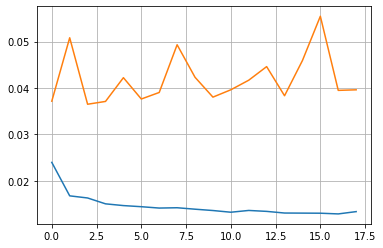


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:38<00:05,  5.95s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_896"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_299 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1788 (Dense)             (None, 42)           1806        ['input_299[0][0]']              
                                                                                                  
 multiply_298 (Multiply)        (None, 42)           0           ['input_299[0][0]',              
                                                                  'dense_1788[0][0]']             
                                                                             

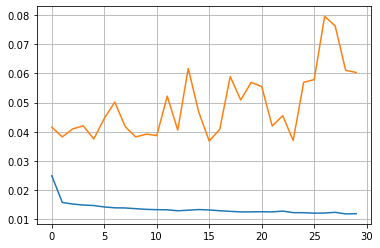


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_899"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_300 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1794 (Dense)             (None, 42)           1806        ['input_300[0][0]']              
                                                                                                  
 multiply_299 (Multiply)        (None, 42)           0           ['input_300[0][0]',              
                                                                  'dense_1794[0][0]']             
                                                                             

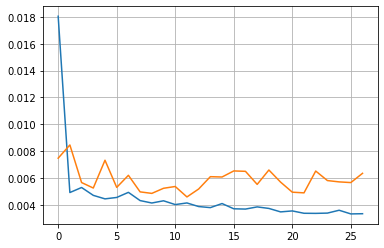


 14%|████████████                                                                        | 1/7 [00:07<00:43,  7.25s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_902"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_301 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1800 (Dense)             (None, 42)           1806        ['input_301[0][0]']              
                                                                                                  
 multiply_300 (Multiply)        (None, 42)           0           ['input_301[0][0]',              
                                                                  'dense_1800[0][0]']             
                                                                             

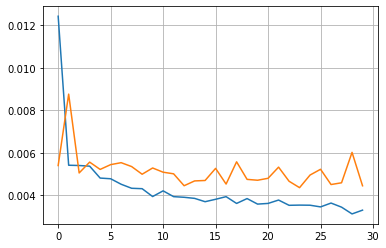


 29%|████████████████████████                                                            | 2/7 [00:14<00:35,  7.14s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_905"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_302 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1806 (Dense)             (None, 42)           1806        ['input_302[0][0]']              
                                                                                                  
 multiply_301 (Multiply)        (None, 42)           0           ['input_302[0][0]',              
                                                                  'dense_1806[0][0]']             
                                                                             

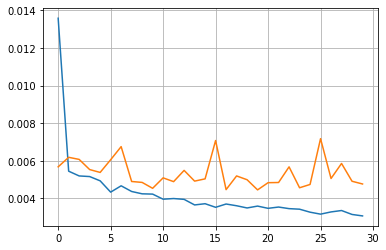


 43%|████████████████████████████████████                                                | 3/7 [00:23<00:31,  7.90s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_908"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_303 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1812 (Dense)             (None, 42)           1806        ['input_303[0][0]']              
                                                                                                  
 multiply_302 (Multiply)        (None, 42)           0           ['input_303[0][0]',              
                                                                  'dense_1812[0][0]']             
                                                                             

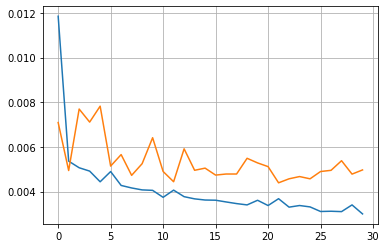


 57%|████████████████████████████████████████████████                                    | 4/7 [00:30<00:22,  7.57s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_911"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_304 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1818 (Dense)             (None, 42)           1806        ['input_304[0][0]']              
                                                                                                  
 multiply_303 (Multiply)        (None, 42)           0           ['input_304[0][0]',              
                                                                  'dense_1818[0][0]']             
                                                                             

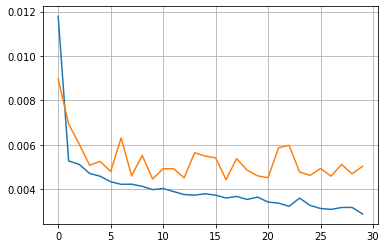


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:38<00:15,  7.97s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_914"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_305 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1824 (Dense)             (None, 42)           1806        ['input_305[0][0]']              
                                                                                                  
 multiply_304 (Multiply)        (None, 42)           0           ['input_305[0][0]',              
                                                                  'dense_1824[0][0]']             
                                                                             

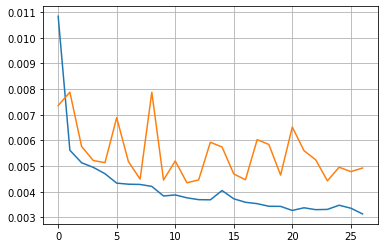


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:46<00:07,  7.93s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_917"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_306 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1830 (Dense)             (None, 42)           1806        ['input_306[0][0]']              
                                                                                                  
 multiply_305 (Multiply)        (None, 42)           0           ['input_306[0][0]',              
                                                                  'dense_1830[0][0]']             
                                                                             

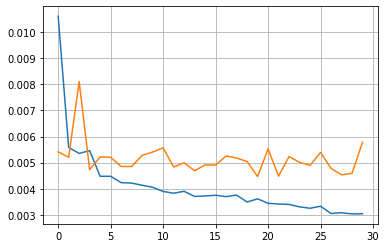


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_920"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_307 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1836 (Dense)             (None, 42)           1806        ['input_307[0][0]']              
                                                                                                  
 multiply_306 (Multiply)        (None, 42)           0           ['input_307[0][0]',              
                                                                  'dense_1836[0][0]']             
                                                                             

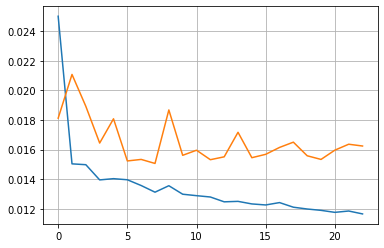


 14%|████████████                                                                        | 1/7 [00:05<00:34,  5.73s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_923"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_308 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1842 (Dense)             (None, 42)           1806        ['input_308[0][0]']              
                                                                                                  
 multiply_307 (Multiply)        (None, 42)           0           ['input_308[0][0]',              
                                                                  'dense_1842[0][0]']             
                                                                             

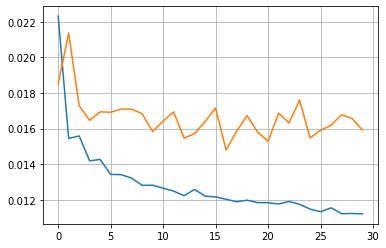


 29%|████████████████████████                                                            | 2/7 [00:13<00:33,  6.78s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_926"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_309 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1848 (Dense)             (None, 42)           1806        ['input_309[0][0]']              
                                                                                                  
 multiply_308 (Multiply)        (None, 42)           0           ['input_309[0][0]',              
                                                                  'dense_1848[0][0]']             
                                                                             

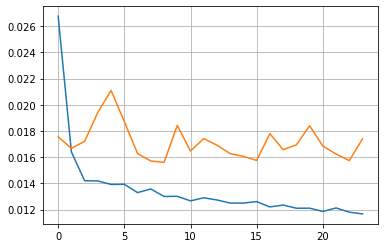


 43%|████████████████████████████████████                                                | 3/7 [00:19<00:26,  6.64s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_929"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_310 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1854 (Dense)             (None, 42)           1806        ['input_310[0][0]']              
                                                                                                  
 multiply_309 (Multiply)        (None, 42)           0           ['input_310[0][0]',              
                                                                  'dense_1854[0][0]']             
                                                                             

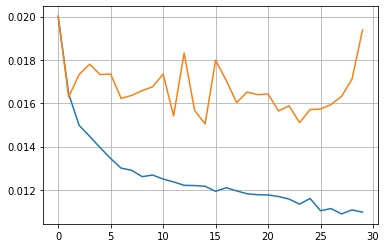


 57%|████████████████████████████████████████████████                                    | 4/7 [00:26<00:20,  6.79s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_932"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_311 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1860 (Dense)             (None, 42)           1806        ['input_311[0][0]']              
                                                                                                  
 multiply_310 (Multiply)        (None, 42)           0           ['input_311[0][0]',              
                                                                  'dense_1860[0][0]']             
                                                                             

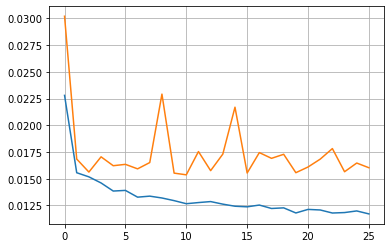


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:33<00:13,  6.76s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_935"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_312 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1866 (Dense)             (None, 42)           1806        ['input_312[0][0]']              
                                                                                                  
 multiply_311 (Multiply)        (None, 42)           0           ['input_312[0][0]',              
                                                                  'dense_1866[0][0]']             
                                                                             

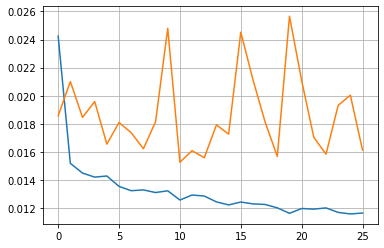


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:40<00:06,  6.72s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_938"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_313 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1872 (Dense)             (None, 42)           1806        ['input_313[0][0]']              
                                                                                                  
 multiply_312 (Multiply)        (None, 42)           0           ['input_313[0][0]',              
                                                                  'dense_1872[0][0]']             
                                                                             

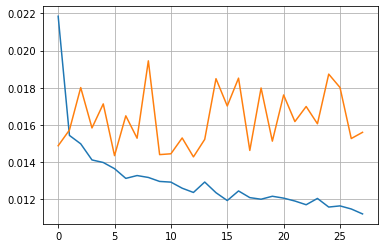


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_941"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_314 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1878 (Dense)             (None, 42)           1806        ['input_314[0][0]']              
                                                                                                  
 multiply_313 (Multiply)        (None, 42)           0           ['input_314[0][0]',              
                                                                  'dense_1878[0][0]']             
                                                                             

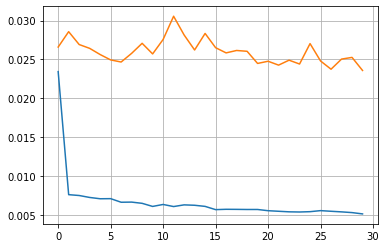


 14%|████████████                                                                        | 1/7 [00:09<00:57,  9.62s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_944"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_315 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1884 (Dense)             (None, 42)           1806        ['input_315[0][0]']              
                                                                                                  
 multiply_314 (Multiply)        (None, 42)           0           ['input_315[0][0]',              
                                                                  'dense_1884[0][0]']             
                                                                             

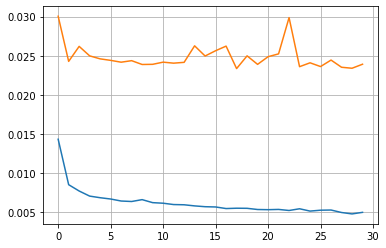


 29%|████████████████████████                                                            | 2/7 [00:16<00:40,  8.09s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_947"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_316 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1890 (Dense)             (None, 42)           1806        ['input_316[0][0]']              
                                                                                                  
 multiply_315 (Multiply)        (None, 42)           0           ['input_316[0][0]',              
                                                                  'dense_1890[0][0]']             
                                                                             

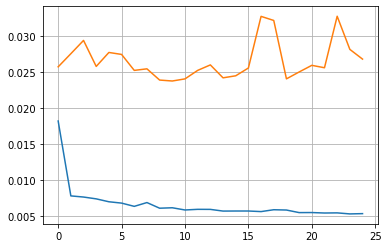


 43%|████████████████████████████████████                                                | 3/7 [00:22<00:28,  7.06s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_950"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_317 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1896 (Dense)             (None, 42)           1806        ['input_317[0][0]']              
                                                                                                  
 multiply_316 (Multiply)        (None, 42)           0           ['input_317[0][0]',              
                                                                  'dense_1896[0][0]']             
                                                                             

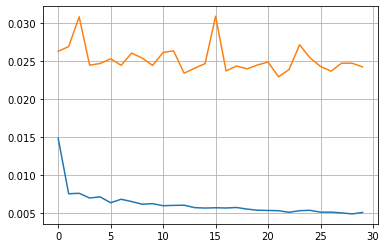


 57%|████████████████████████████████████████████████                                    | 4/7 [00:30<00:21,  7.31s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_953"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_318 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1902 (Dense)             (None, 42)           1806        ['input_318[0][0]']              
                                                                                                  
 multiply_317 (Multiply)        (None, 42)           0           ['input_318[0][0]',              
                                                                  'dense_1902[0][0]']             
                                                                             

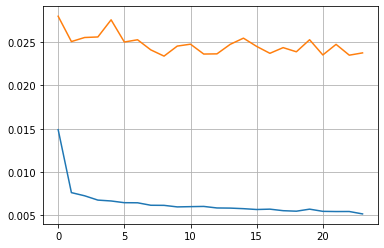


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:36<00:14,  7.00s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_956"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_319 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1908 (Dense)             (None, 42)           1806        ['input_319[0][0]']              
                                                                                                  
 multiply_318 (Multiply)        (None, 42)           0           ['input_319[0][0]',              
                                                                  'dense_1908[0][0]']             
                                                                             

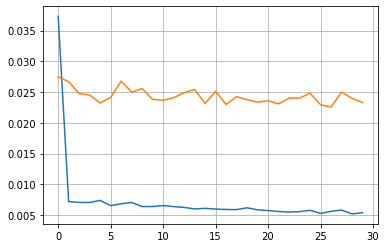


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:46<00:07,  7.88s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_959"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_320 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1914 (Dense)             (None, 42)           1806        ['input_320[0][0]']              
                                                                                                  
 multiply_319 (Multiply)        (None, 42)           0           ['input_320[0][0]',              
                                                                  'dense_1914[0][0]']             
                                                                             

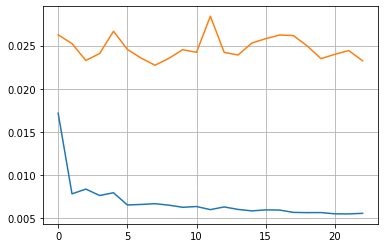


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_962"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_321 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1920 (Dense)             (None, 42)           1806        ['input_321[0][0]']              
                                                                                                  
 multiply_320 (Multiply)        (None, 42)           0           ['input_321[0][0]',              
                                                                  'dense_1920[0][0]']             
                                                                             

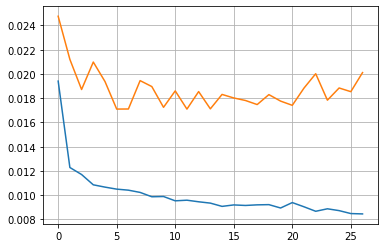


 14%|████████████                                                                        | 1/7 [00:06<00:40,  6.75s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_965"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_322 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1926 (Dense)             (None, 42)           1806        ['input_322[0][0]']              
                                                                                                  
 multiply_321 (Multiply)        (None, 42)           0           ['input_322[0][0]',              
                                                                  'dense_1926[0][0]']             
                                                                             

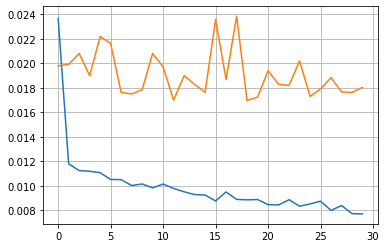


 29%|████████████████████████                                                            | 2/7 [00:14<00:36,  7.30s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_968"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_323 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1932 (Dense)             (None, 42)           1806        ['input_323[0][0]']              
                                                                                                  
 multiply_322 (Multiply)        (None, 42)           0           ['input_323[0][0]',              
                                                                  'dense_1932[0][0]']             
                                                                             

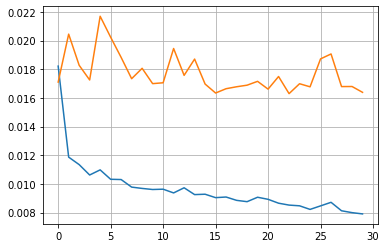


 43%|████████████████████████████████████                                                | 3/7 [00:21<00:28,  7.18s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_971"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_324 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1938 (Dense)             (None, 42)           1806        ['input_324[0][0]']              
                                                                                                  
 multiply_323 (Multiply)        (None, 42)           0           ['input_324[0][0]',              
                                                                  'dense_1938[0][0]']             
                                                                             

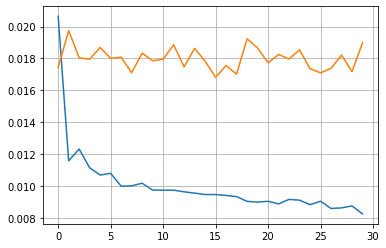


 57%|████████████████████████████████████████████████                                    | 4/7 [00:27<00:19,  6.64s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_974"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_325 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1944 (Dense)             (None, 42)           1806        ['input_325[0][0]']              
                                                                                                  
 multiply_324 (Multiply)        (None, 42)           0           ['input_325[0][0]',              
                                                                  'dense_1944[0][0]']             
                                                                             

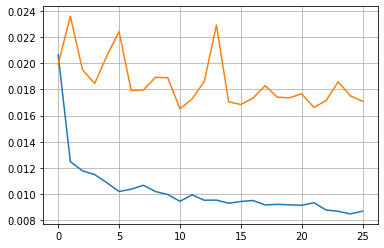


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:33<00:13,  6.65s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_977"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_326 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1950 (Dense)             (None, 42)           1806        ['input_326[0][0]']              
                                                                                                  
 multiply_325 (Multiply)        (None, 42)           0           ['input_326[0][0]',              
                                                                  'dense_1950[0][0]']             
                                                                             

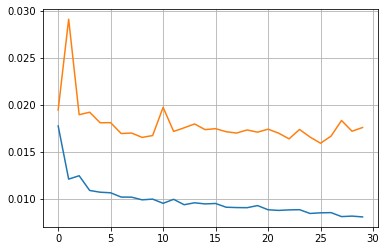


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:42<00:07,  7.21s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_980"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_327 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_1956 (Dense)             (None, 42)           1806        ['input_327[0][0]']              
                                                                                                  
 multiply_326 (Multiply)        (None, 42)           0           ['input_327[0][0]',              
                                                                  'dense_1956[0][0]']             
                                                                             

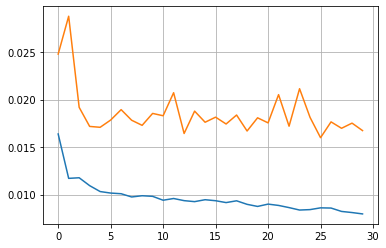


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (3881, 42) Test_size: (1, 42)
X_train: (3881, 41) Y_train: (3881, 1)
X_test: (1, 41) Y_test: (1, 1)
Model: "model_983"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_328 (InputLayer)         [(None, 41)]         0           []                               
                                                                                                  
 dense_1962 (Dense)             (None, 41)           1722        ['input_328[0][0]']              
                                                                                                  
 multiply_327 (Multiply)        (None, 41)           0           ['input_328[0][0]',              
                                                                  'dense_1962[0][0]']             
                                                                             

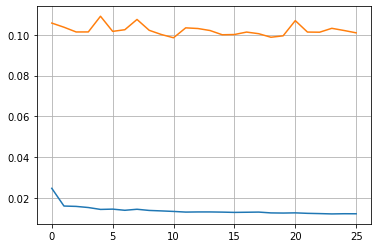


 14%|████████████                                                                        | 1/7 [00:06<00:38,  6.45s/it]

Train_size: (3882, 42) Test_size: (1, 42)
X_train: (3882, 41) Y_train: (3882, 1)
X_test: (1, 41) Y_test: (1, 1)
Model: "model_986"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_329 (InputLayer)         [(None, 41)]         0           []                               
                                                                                                  
 dense_1968 (Dense)             (None, 41)           1722        ['input_329[0][0]']              
                                                                                                  
 multiply_328 (Multiply)        (None, 41)           0           ['input_329[0][0]',              
                                                                  'dense_1968[0][0]']             
                                                                             

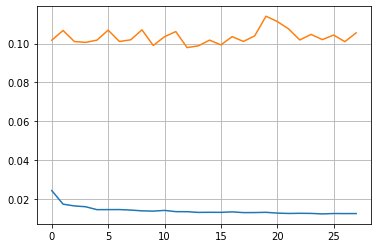


 29%|████████████████████████                                                            | 2/7 [00:13<00:33,  6.70s/it]

Train_size: (3883, 42) Test_size: (1, 42)
X_train: (3883, 41) Y_train: (3883, 1)
X_test: (1, 41) Y_test: (1, 1)
Model: "model_989"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_330 (InputLayer)         [(None, 41)]         0           []                               
                                                                                                  
 dense_1974 (Dense)             (None, 41)           1722        ['input_330[0][0]']              
                                                                                                  
 multiply_329 (Multiply)        (None, 41)           0           ['input_330[0][0]',              
                                                                  'dense_1974[0][0]']             
                                                                             

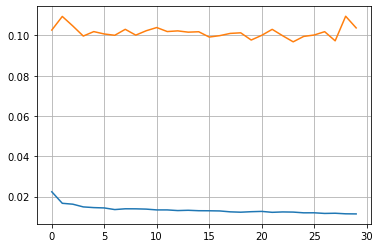


 43%|████████████████████████████████████                                                | 3/7 [00:20<00:27,  6.77s/it]

Train_size: (3884, 42) Test_size: (1, 42)
X_train: (3884, 41) Y_train: (3884, 1)
X_test: (1, 41) Y_test: (1, 1)
Model: "model_992"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_331 (InputLayer)         [(None, 41)]         0           []                               
                                                                                                  
 dense_1980 (Dense)             (None, 41)           1722        ['input_331[0][0]']              
                                                                                                  
 multiply_330 (Multiply)        (None, 41)           0           ['input_331[0][0]',              
                                                                  'dense_1980[0][0]']             
                                                                             

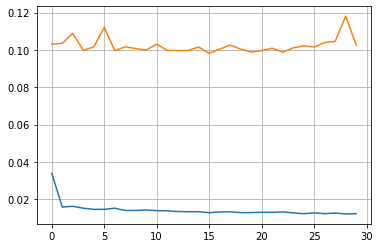


 57%|████████████████████████████████████████████████                                    | 4/7 [00:26<00:19,  6.59s/it]

Train_size: (3885, 42) Test_size: (1, 42)
X_train: (3885, 41) Y_train: (3885, 1)
X_test: (1, 41) Y_test: (1, 1)
Model: "model_995"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_332 (InputLayer)         [(None, 41)]         0           []                               
                                                                                                  
 dense_1986 (Dense)             (None, 41)           1722        ['input_332[0][0]']              
                                                                                                  
 multiply_331 (Multiply)        (None, 41)           0           ['input_332[0][0]',              
                                                                  'dense_1986[0][0]']             
                                                                             

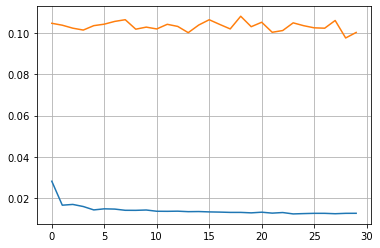


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:33<00:13,  6.87s/it]

Train_size: (3886, 42) Test_size: (1, 42)
X_train: (3886, 41) Y_train: (3886, 1)
X_test: (1, 41) Y_test: (1, 1)
Model: "model_998"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_333 (InputLayer)         [(None, 41)]         0           []                               
                                                                                                  
 dense_1992 (Dense)             (None, 41)           1722        ['input_333[0][0]']              
                                                                                                  
 multiply_332 (Multiply)        (None, 41)           0           ['input_333[0][0]',              
                                                                  'dense_1992[0][0]']             
                                                                             

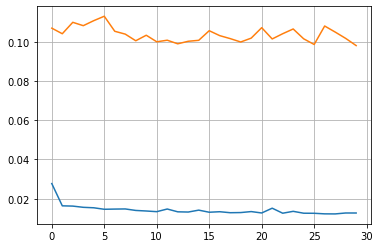


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:42<00:07,  7.51s/it]

Train_size: (3887, 42) Test_size: (1, 42)
X_train: (3887, 41) Y_train: (3887, 1)
X_test: (1, 41) Y_test: (1, 1)
Model: "model_1001"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_334 (InputLayer)         [(None, 41)]         0           []                               
                                                                                                  
 dense_1998 (Dense)             (None, 41)           1722        ['input_334[0][0]']              
                                                                                                  
 multiply_333 (Multiply)        (None, 41)           0           ['input_334[0][0]',              
                                                                  'dense_1998[0][0]']             
                                                                            

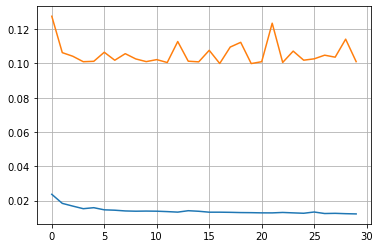


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1004"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_335 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2004 (Dense)             (None, 42)           1806        ['input_335[0][0]']              
                                                                                                  
 multiply_334 (Multiply)        (None, 42)           0           ['input_335[0][0]',              
                                                                  'dense_2004[0][0]']             
                                                                            

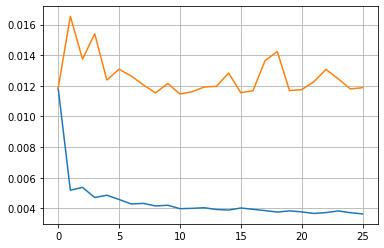


 14%|████████████                                                                        | 1/7 [00:05<00:33,  5.61s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1007"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_336 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2010 (Dense)             (None, 42)           1806        ['input_336[0][0]']              
                                                                                                  
 multiply_335 (Multiply)        (None, 42)           0           ['input_336[0][0]',              
                                                                  'dense_2010[0][0]']             
                                                                            

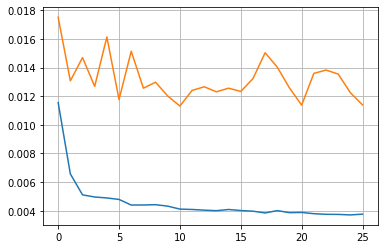


 29%|████████████████████████                                                            | 2/7 [00:12<00:31,  6.27s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1010"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_337 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2016 (Dense)             (None, 42)           1806        ['input_337[0][0]']              
                                                                                                  
 multiply_336 (Multiply)        (None, 42)           0           ['input_337[0][0]',              
                                                                  'dense_2016[0][0]']             
                                                                            

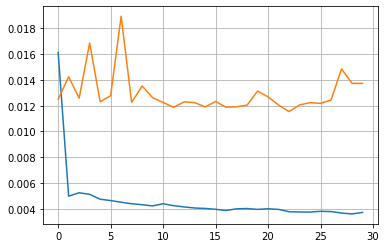


 43%|████████████████████████████████████                                                | 3/7 [00:20<00:27,  6.91s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1013"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_338 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2022 (Dense)             (None, 42)           1806        ['input_338[0][0]']              
                                                                                                  
 multiply_337 (Multiply)        (None, 42)           0           ['input_338[0][0]',              
                                                                  'dense_2022[0][0]']             
                                                                            

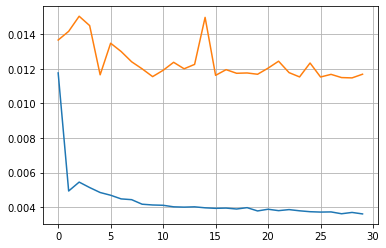


 57%|████████████████████████████████████████████████                                    | 4/7 [00:28<00:22,  7.42s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1016"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_339 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2028 (Dense)             (None, 42)           1806        ['input_339[0][0]']              
                                                                                                  
 multiply_338 (Multiply)        (None, 42)           0           ['input_339[0][0]',              
                                                                  'dense_2028[0][0]']             
                                                                            

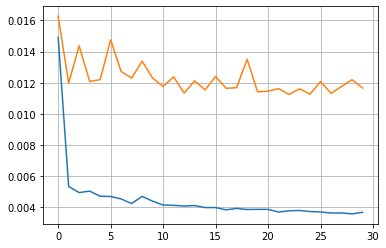


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:35<00:14,  7.27s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1019"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_340 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2034 (Dense)             (None, 42)           1806        ['input_340[0][0]']              
                                                                                                  
 multiply_339 (Multiply)        (None, 42)           0           ['input_340[0][0]',              
                                                                  'dense_2034[0][0]']             
                                                                            

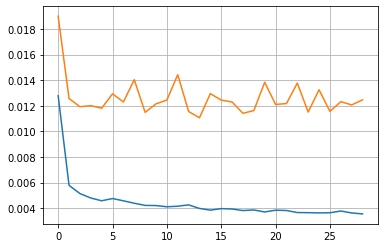


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:42<00:07,  7.41s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1022"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_341 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2040 (Dense)             (None, 42)           1806        ['input_341[0][0]']              
                                                                                                  
 multiply_340 (Multiply)        (None, 42)           0           ['input_341[0][0]',              
                                                                  'dense_2040[0][0]']             
                                                                            

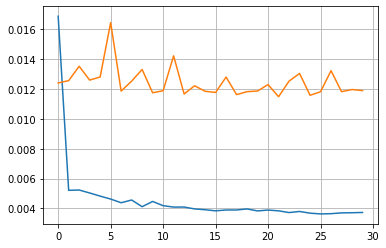


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4147, 43) Test_size: (1, 43)
X_train: (4147, 42) Y_train: (4147, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1025"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_342 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2046 (Dense)             (None, 42)           1806        ['input_342[0][0]']              
                                                                                                  
 multiply_341 (Multiply)        (None, 42)           0           ['input_342[0][0]',              
                                                                  'dense_2046[0][0]']             
                                                                            

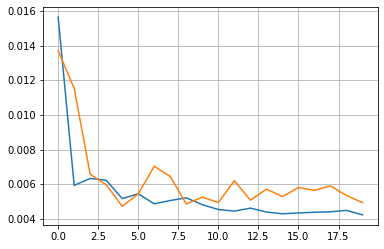


 14%|████████████                                                                        | 1/7 [00:06<00:36,  6.15s/it]

Train_size: (4148, 43) Test_size: (1, 43)
X_train: (4148, 42) Y_train: (4148, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1028"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_343 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2052 (Dense)             (None, 42)           1806        ['input_343[0][0]']              
                                                                                                  
 multiply_342 (Multiply)        (None, 42)           0           ['input_343[0][0]',              
                                                                  'dense_2052[0][0]']             
                                                                            

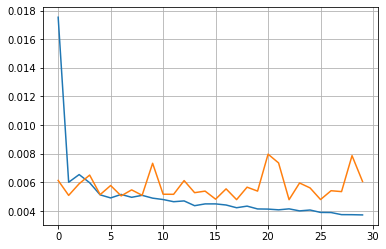


 29%|████████████████████████                                                            | 2/7 [00:13<00:35,  7.03s/it]

Train_size: (4149, 43) Test_size: (1, 43)
X_train: (4149, 42) Y_train: (4149, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1031"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_344 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2058 (Dense)             (None, 42)           1806        ['input_344[0][0]']              
                                                                                                  
 multiply_343 (Multiply)        (None, 42)           0           ['input_344[0][0]',              
                                                                  'dense_2058[0][0]']             
                                                                            

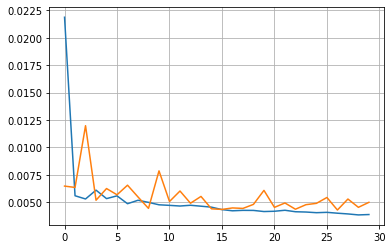


 43%|████████████████████████████████████                                                | 3/7 [00:22<00:30,  7.62s/it]

Train_size: (4150, 43) Test_size: (1, 43)
X_train: (4150, 42) Y_train: (4150, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1034"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_345 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2064 (Dense)             (None, 42)           1806        ['input_345[0][0]']              
                                                                                                  
 multiply_344 (Multiply)        (None, 42)           0           ['input_345[0][0]',              
                                                                  'dense_2064[0][0]']             
                                                                            

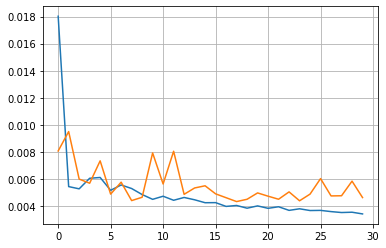


 57%|████████████████████████████████████████████████                                    | 4/7 [00:29<00:23,  7.70s/it]

Train_size: (4151, 43) Test_size: (1, 43)
X_train: (4151, 42) Y_train: (4151, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1037"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_346 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2070 (Dense)             (None, 42)           1806        ['input_346[0][0]']              
                                                                                                  
 multiply_345 (Multiply)        (None, 42)           0           ['input_346[0][0]',              
                                                                  'dense_2070[0][0]']             
                                                                            

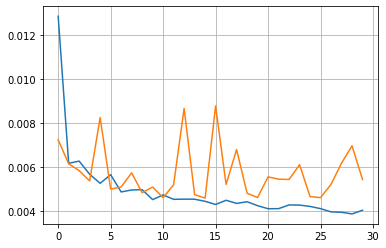


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:38<00:16,  8.07s/it]

Train_size: (4152, 43) Test_size: (1, 43)
X_train: (4152, 42) Y_train: (4152, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1040"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_347 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2076 (Dense)             (None, 42)           1806        ['input_347[0][0]']              
                                                                                                  
 multiply_346 (Multiply)        (None, 42)           0           ['input_347[0][0]',              
                                                                  'dense_2076[0][0]']             
                                                                            

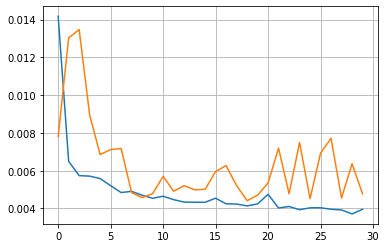


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:45<00:07,  7.74s/it]

Train_size: (4153, 43) Test_size: (1, 43)
X_train: (4153, 42) Y_train: (4153, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1043"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_348 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2082 (Dense)             (None, 42)           1806        ['input_348[0][0]']              
                                                                                                  
 multiply_347 (Multiply)        (None, 42)           0           ['input_348[0][0]',              
                                                                  'dense_2082[0][0]']             
                                                                            

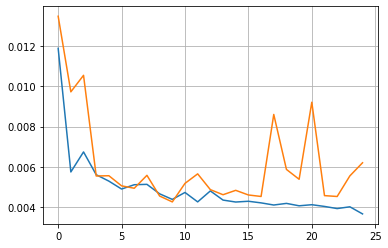


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (2635, 39) Test_size: (1, 39)
X_train: (2635, 38) Y_train: (2635, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_1046"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_349 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_2088 (Dense)             (None, 38)           1482        ['input_349[0][0]']              
                                                                                                  
 multiply_348 (Multiply)        (None, 38)           0           ['input_349[0][0]',              
                                                                  'dense_2088[0][0]']             
                                                                            

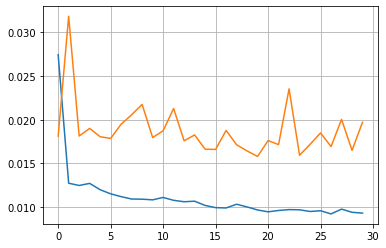


 14%|████████████                                                                        | 1/7 [00:07<00:44,  7.48s/it]

Train_size: (2636, 39) Test_size: (1, 39)
X_train: (2636, 38) Y_train: (2636, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_1049"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_350 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_2094 (Dense)             (None, 38)           1482        ['input_350[0][0]']              
                                                                                                  
 multiply_349 (Multiply)        (None, 38)           0           ['input_350[0][0]',              
                                                                  'dense_2094[0][0]']             
                                                                            

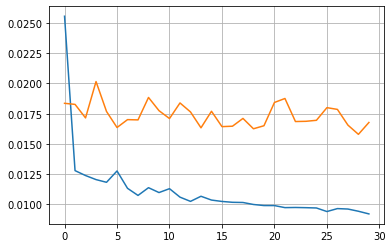


 29%|████████████████████████                                                            | 2/7 [00:14<00:36,  7.24s/it]

Train_size: (2637, 39) Test_size: (1, 39)
X_train: (2637, 38) Y_train: (2637, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_1052"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_351 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_2100 (Dense)             (None, 38)           1482        ['input_351[0][0]']              
                                                                                                  
 multiply_350 (Multiply)        (None, 38)           0           ['input_351[0][0]',              
                                                                  'dense_2100[0][0]']             
                                                                            

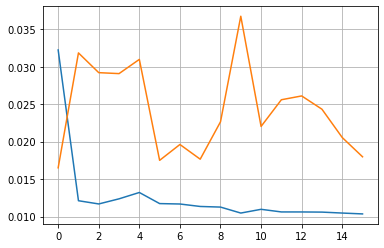


 43%|████████████████████████████████████                                                | 3/7 [00:17<00:20,  5.20s/it]

Train_size: (2638, 39) Test_size: (1, 39)
X_train: (2638, 38) Y_train: (2638, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_1055"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_352 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_2106 (Dense)             (None, 38)           1482        ['input_352[0][0]']              
                                                                                                  
 multiply_351 (Multiply)        (None, 38)           0           ['input_352[0][0]',              
                                                                  'dense_2106[0][0]']             
                                                                            

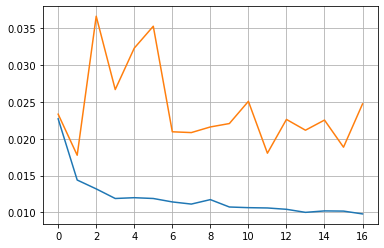


 57%|████████████████████████████████████████████████                                    | 4/7 [00:20<00:13,  4.55s/it]

Train_size: (2639, 39) Test_size: (1, 39)
X_train: (2639, 38) Y_train: (2639, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_1058"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_353 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_2112 (Dense)             (None, 38)           1482        ['input_353[0][0]']              
                                                                                                  
 multiply_352 (Multiply)        (None, 38)           0           ['input_353[0][0]',              
                                                                  'dense_2112[0][0]']             
                                                                            

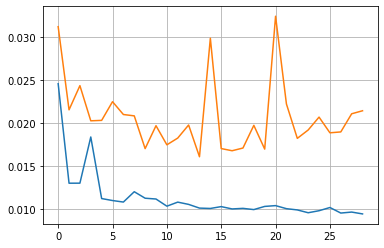


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:26<00:10,  5.05s/it]

Train_size: (2640, 39) Test_size: (1, 39)
X_train: (2640, 38) Y_train: (2640, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_1061"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_354 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_2118 (Dense)             (None, 38)           1482        ['input_354[0][0]']              
                                                                                                  
 multiply_353 (Multiply)        (None, 38)           0           ['input_354[0][0]',              
                                                                  'dense_2118[0][0]']             
                                                                            

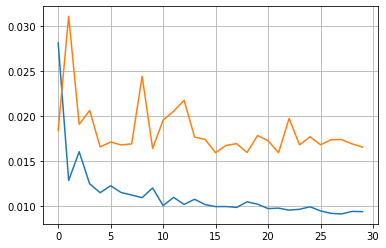


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:32<00:05,  5.16s/it]

Train_size: (2641, 39) Test_size: (1, 39)
X_train: (2641, 38) Y_train: (2641, 1)
X_test: (1, 38) Y_test: (1, 1)
Model: "model_1064"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_355 (InputLayer)         [(None, 38)]         0           []                               
                                                                                                  
 dense_2124 (Dense)             (None, 38)           1482        ['input_355[0][0]']              
                                                                                                  
 multiply_354 (Multiply)        (None, 38)           0           ['input_355[0][0]',              
                                                                  'dense_2124[0][0]']             
                                                                            

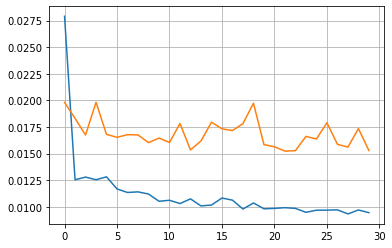


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1067"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_356 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2130 (Dense)             (None, 42)           1806        ['input_356[0][0]']              
                                                                                                  
 multiply_355 (Multiply)        (None, 42)           0           ['input_356[0][0]',              
                                                                  'dense_2130[0][0]']             
                                                                            

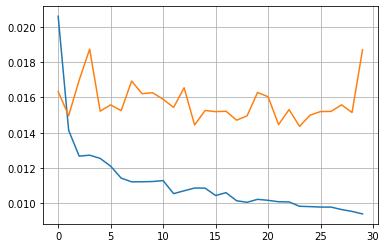


 14%|████████████                                                                        | 1/7 [00:06<00:38,  6.42s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1070"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_357 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2136 (Dense)             (None, 42)           1806        ['input_357[0][0]']              
                                                                                                  
 multiply_356 (Multiply)        (None, 42)           0           ['input_357[0][0]',              
                                                                  'dense_2136[0][0]']             
                                                                            

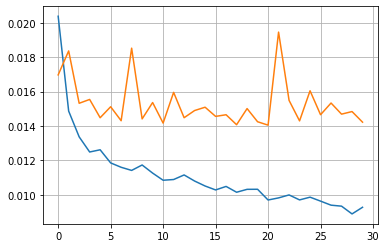


 29%|████████████████████████                                                            | 2/7 [00:14<00:37,  7.51s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1073"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_358 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2142 (Dense)             (None, 42)           1806        ['input_358[0][0]']              
                                                                                                  
 multiply_357 (Multiply)        (None, 42)           0           ['input_358[0][0]',              
                                                                  'dense_2142[0][0]']             
                                                                            

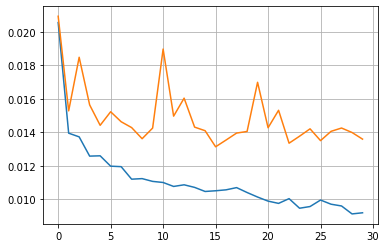


 43%|████████████████████████████████████                                                | 3/7 [00:22<00:30,  7.59s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1076"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_359 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2148 (Dense)             (None, 42)           1806        ['input_359[0][0]']              
                                                                                                  
 multiply_358 (Multiply)        (None, 42)           0           ['input_359[0][0]',              
                                                                  'dense_2148[0][0]']             
                                                                            

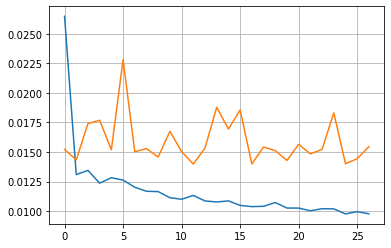


 57%|████████████████████████████████████████████████                                    | 4/7 [00:28<00:20,  6.90s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1079"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_360 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2154 (Dense)             (None, 42)           1806        ['input_360[0][0]']              
                                                                                                  
 multiply_359 (Multiply)        (None, 42)           0           ['input_360[0][0]',              
                                                                  'dense_2154[0][0]']             
                                                                            

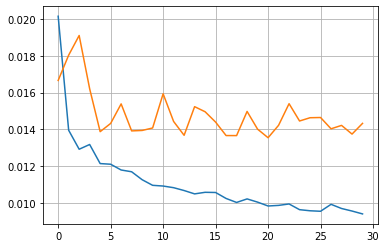


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:36<00:14,  7.38s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1082"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_361 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2160 (Dense)             (None, 42)           1806        ['input_361[0][0]']              
                                                                                                  
 multiply_360 (Multiply)        (None, 42)           0           ['input_361[0][0]',              
                                                                  'dense_2160[0][0]']             
                                                                            

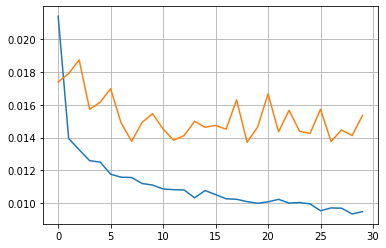


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:43<00:07,  7.33s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1085"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_362 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2166 (Dense)             (None, 42)           1806        ['input_362[0][0]']              
                                                                                                  
 multiply_361 (Multiply)        (None, 42)           0           ['input_362[0][0]',              
                                                                  'dense_2166[0][0]']             
                                                                            

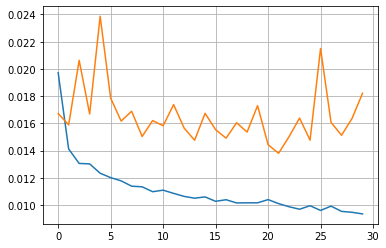


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1088"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_363 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2172 (Dense)             (None, 42)           1806        ['input_363[0][0]']              
                                                                                                  
 multiply_362 (Multiply)        (None, 42)           0           ['input_363[0][0]',              
                                                                  'dense_2172[0][0]']             
                                                                            

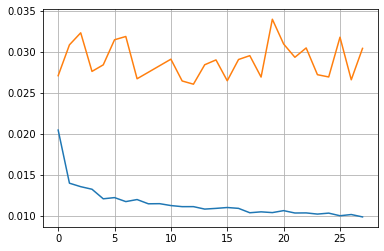


 14%|████████████                                                                        | 1/7 [00:06<00:38,  6.42s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1091"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_364 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2178 (Dense)             (None, 42)           1806        ['input_364[0][0]']              
                                                                                                  
 multiply_363 (Multiply)        (None, 42)           0           ['input_364[0][0]',              
                                                                  'dense_2178[0][0]']             
                                                                            

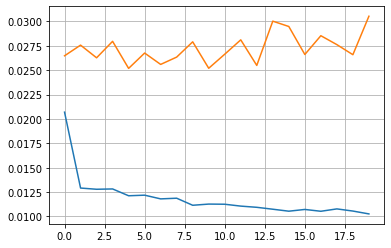


 29%|████████████████████████                                                            | 2/7 [00:11<00:28,  5.64s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1094"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_365 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2184 (Dense)             (None, 42)           1806        ['input_365[0][0]']              
                                                                                                  
 multiply_364 (Multiply)        (None, 42)           0           ['input_365[0][0]',              
                                                                  'dense_2184[0][0]']             
                                                                            

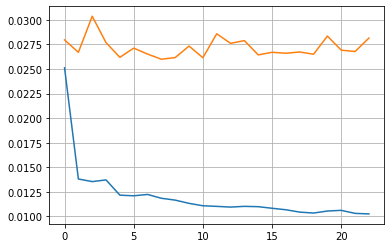


 43%|████████████████████████████████████                                                | 3/7 [00:17<00:23,  5.77s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1097"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_366 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2190 (Dense)             (None, 42)           1806        ['input_366[0][0]']              
                                                                                                  
 multiply_365 (Multiply)        (None, 42)           0           ['input_366[0][0]',              
                                                                  'dense_2190[0][0]']             
                                                                            

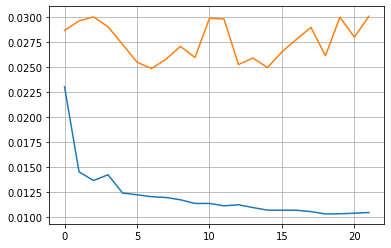


 57%|████████████████████████████████████████████████                                    | 4/7 [00:23<00:17,  5.78s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1100"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_367 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2196 (Dense)             (None, 42)           1806        ['input_367[0][0]']              
                                                                                                  
 multiply_366 (Multiply)        (None, 42)           0           ['input_367[0][0]',              
                                                                  'dense_2196[0][0]']             
                                                                            

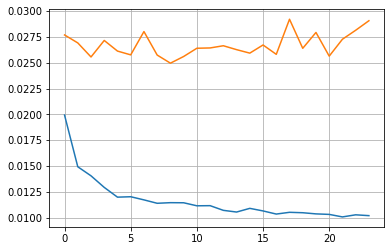


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:29<00:11,  5.86s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1103"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_368 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2202 (Dense)             (None, 42)           1806        ['input_368[0][0]']              
                                                                                                  
 multiply_367 (Multiply)        (None, 42)           0           ['input_368[0][0]',              
                                                                  'dense_2202[0][0]']             
                                                                            

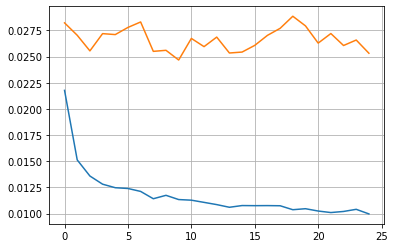


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:35<00:06,  6.11s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1106"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_369 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2208 (Dense)             (None, 42)           1806        ['input_369[0][0]']              
                                                                                                  
 multiply_368 (Multiply)        (None, 42)           0           ['input_369[0][0]',              
                                                                  'dense_2208[0][0]']             
                                                                            

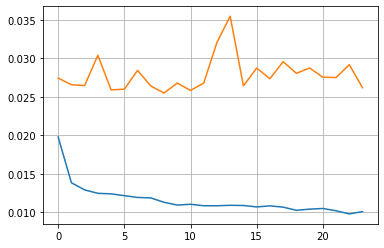


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1109"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_370 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2214 (Dense)             (None, 42)           1806        ['input_370[0][0]']              
                                                                                                  
 multiply_369 (Multiply)        (None, 42)           0           ['input_370[0][0]',              
                                                                  'dense_2214[0][0]']             
                                                                            

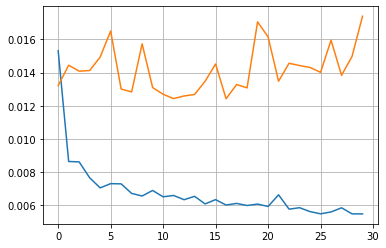


 14%|████████████                                                                        | 1/7 [00:07<00:45,  7.64s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1112"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_371 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2220 (Dense)             (None, 42)           1806        ['input_371[0][0]']              
                                                                                                  
 multiply_370 (Multiply)        (None, 42)           0           ['input_371[0][0]',              
                                                                  'dense_2220[0][0]']             
                                                                            

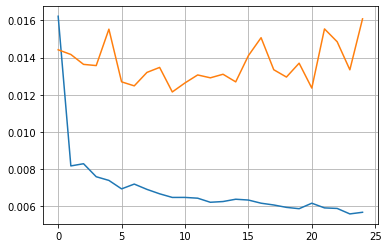


 29%|████████████████████████                                                            | 2/7 [00:15<00:38,  7.69s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1115"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_372 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2226 (Dense)             (None, 42)           1806        ['input_372[0][0]']              
                                                                                                  
 multiply_371 (Multiply)        (None, 42)           0           ['input_372[0][0]',              
                                                                  'dense_2226[0][0]']             
                                                                            

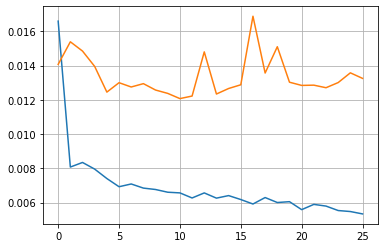


 43%|████████████████████████████████████                                                | 3/7 [00:22<00:29,  7.29s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1118"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_373 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2232 (Dense)             (None, 42)           1806        ['input_373[0][0]']              
                                                                                                  
 multiply_372 (Multiply)        (None, 42)           0           ['input_373[0][0]',              
                                                                  'dense_2232[0][0]']             
                                                                            

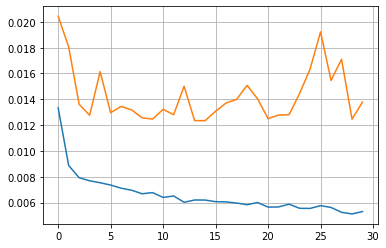


 57%|████████████████████████████████████████████████                                    | 4/7 [00:31<00:23,  7.91s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_374 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2238 (Dense)             (None, 42)           1806        ['input_374[0][0]']              
                                                                                                  
 multiply_373 (Multiply)        (None, 42)           0           ['input_374[0][0]',              
                                                                  'dense_2238[0][0]']             
                                                                            

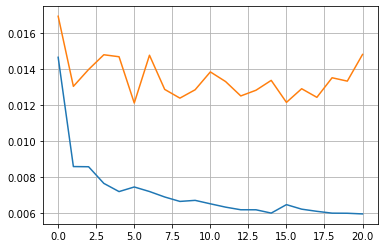


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:36<00:13,  6.91s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1124"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_375 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2244 (Dense)             (None, 42)           1806        ['input_375[0][0]']              
                                                                                                  
 multiply_374 (Multiply)        (None, 42)           0           ['input_375[0][0]',              
                                                                  'dense_2244[0][0]']             
                                                                            

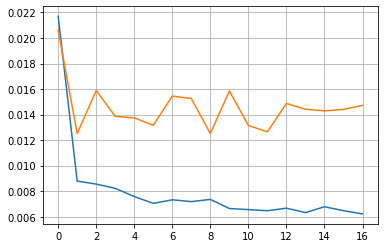


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:40<00:05,  5.95s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1127"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_376 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2250 (Dense)             (None, 42)           1806        ['input_376[0][0]']              
                                                                                                  
 multiply_375 (Multiply)        (None, 42)           0           ['input_376[0][0]',              
                                                                  'dense_2250[0][0]']             
                                                                            

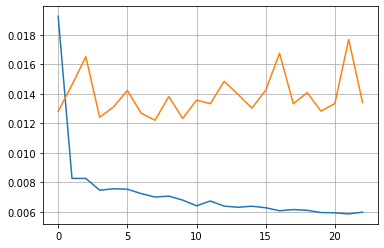


  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Train_size: (4182, 43) Test_size: (1, 43)
X_train: (4182, 42) Y_train: (4182, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1130"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_377 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2256 (Dense)             (None, 42)           1806        ['input_377[0][0]']              
                                                                                                  
 multiply_376 (Multiply)        (None, 42)           0           ['input_377[0][0]',              
                                                                  'dense_2256[0][0]']             
                                                                            

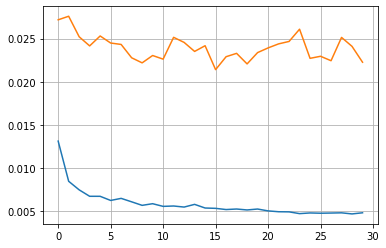


 14%|████████████                                                                        | 1/7 [00:07<00:45,  7.54s/it]

Train_size: (4183, 43) Test_size: (1, 43)
X_train: (4183, 42) Y_train: (4183, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1133"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_378 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2262 (Dense)             (None, 42)           1806        ['input_378[0][0]']              
                                                                                                  
 multiply_377 (Multiply)        (None, 42)           0           ['input_378[0][0]',              
                                                                  'dense_2262[0][0]']             
                                                                            

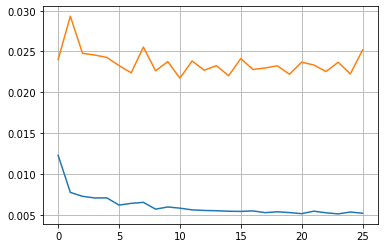


 29%|████████████████████████                                                            | 2/7 [00:13<00:33,  6.70s/it]

Train_size: (4184, 43) Test_size: (1, 43)
X_train: (4184, 42) Y_train: (4184, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1136"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_379 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2268 (Dense)             (None, 42)           1806        ['input_379[0][0]']              
                                                                                                  
 multiply_378 (Multiply)        (None, 42)           0           ['input_379[0][0]',              
                                                                  'dense_2268[0][0]']             
                                                                            

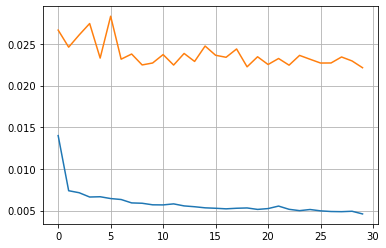


 43%|████████████████████████████████████                                                | 3/7 [00:22<00:30,  7.67s/it]

Train_size: (4185, 43) Test_size: (1, 43)
X_train: (4185, 42) Y_train: (4185, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1139"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_380 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2274 (Dense)             (None, 42)           1806        ['input_380[0][0]']              
                                                                                                  
 multiply_379 (Multiply)        (None, 42)           0           ['input_380[0][0]',              
                                                                  'dense_2274[0][0]']             
                                                                            

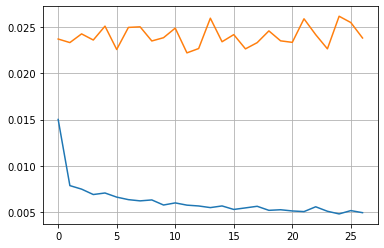


 57%|████████████████████████████████████████████████                                    | 4/7 [00:28<00:21,  7.14s/it]

Train_size: (4186, 43) Test_size: (1, 43)
X_train: (4186, 42) Y_train: (4186, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1142"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_381 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2280 (Dense)             (None, 42)           1806        ['input_381[0][0]']              
                                                                                                  
 multiply_380 (Multiply)        (None, 42)           0           ['input_381[0][0]',              
                                                                  'dense_2280[0][0]']             
                                                                            

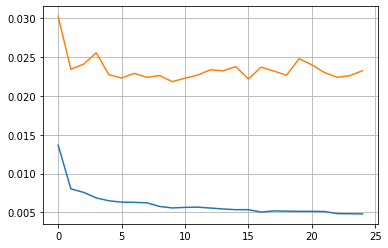


 71%|████████████████████████████████████████████████████████████                        | 5/7 [00:35<00:13,  6.96s/it]

Train_size: (4187, 43) Test_size: (1, 43)
X_train: (4187, 42) Y_train: (4187, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1145"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_382 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2286 (Dense)             (None, 42)           1806        ['input_382[0][0]']              
                                                                                                  
 multiply_381 (Multiply)        (None, 42)           0           ['input_382[0][0]',              
                                                                  'dense_2286[0][0]']             
                                                                            

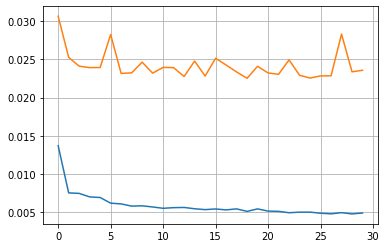


 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [00:43<00:07,  7.43s/it]

Train_size: (4188, 43) Test_size: (1, 43)
X_train: (4188, 42) Y_train: (4188, 1)
X_test: (1, 42) Y_test: (1, 1)
Model: "model_1148"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_383 (InputLayer)         [(None, 42)]         0           []                               
                                                                                                  
 dense_2292 (Dense)             (None, 42)           1806        ['input_383[0][0]']              
                                                                                                  
 multiply_382 (Multiply)        (None, 42)           0           ['input_383[0][0]',              
                                                                  'dense_2292[0][0]']             
                                                                            

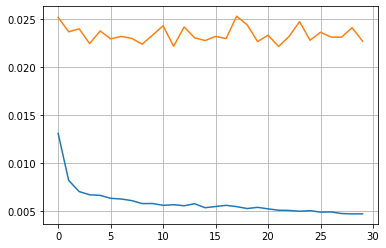


100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [24:05<00:00, 51.64s/it]


In [83]:
Pred_V = pd.DataFrame()
split=365
batch_size = 32
epoch = 100
verbose = 0
dropout_ratio = 0
with tf.device("/device:CPU:0"):
    for PDNAME in tqdm(range(len(Poom))):    
        raw = raw_data(Poom[PDNAME])        
        #Train,Test split
        train=raw[raw.index <= f'{year}-{month}-{day}']
        raw_idx = raw.index
        train_idx = train.index
        
        train = train.iloc[:,:1]
        
        train = feature_engineering(train)
        
        train.index = train_idx
        train = train.iloc[1:]
        Y_colname = ['1dayafter']
        X_colname = [x for x in train.columns if x not in Y_colname]
        for i in tqdm(range(0,7)):
            
            x = str(datetime(year, month, day)+timedelta(days=i))                
            X_train_fe, X_test_fe, Y_train_fe, Y_test_fe = datasplit_ts(train, Y_colname, X_colname, x)
            
            
            x_train = X_train_fe[:-split]
            y_train = Y_train_fe[:-split]
            x_valid = X_train_fe[-split:]
            y_valid = Y_train_fe[-split:]        
            
            y_train= np.array(y_train).reshape(-1,1)
            y_valid= np.array(y_valid).reshape(-1,1)
            
            
            # Parameters
            scaler_X_tr = preprocessing.MinMaxScaler(feature_range=(-1,1))
            scaler_Y_tr = preprocessing.MinMaxScaler(feature_range=(-1,1))
            
            ## Scaling
            X_train = scaler_X_tr.fit_transform(x_train)
            X_valid = scaler_X_tr.transform(x_valid)
            Y_train = scaler_Y_tr.fit_transform(y_train)
            Y_valid = scaler_Y_tr.transform(y_valid)
            
            seed_scaled = scaler_X_tr.transform(X_test_fe)
            earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
                                             patience=30
                                            ,verbose=0, restore_best_weights=True) # 30회 Epoch동안 개선되지 않는다면 종료
            model_path = f'./save_model_{Poom[PDNAME][:-19]}/attention_MLP_{i}'
            mc = ModelCheckpoint(filepath=model_path, save_best_only=True, monitor='val_loss', mode='auto', verbose=0)
            
            # MLP
            inputs = Input(shape=(X_train.shape[1],))
            Selection = Dense(X_train.shape[1], activation='softmax')(inputs)
            Selection = Model(inputs=inputs, outputs=Selection)
            Extraction = Dense(X_train.shape[1], activation='tanh')(inputs)
            Extraction = Model(inputs=inputs, outputs=Extraction)
            x_multiply = Multiply()([inputs,Selection.output])
            Added = Add()([x_multiply, Extraction.output])
            hidden1 = Dense(64, activation='elu')(Added)
            hidden2 = Dense(128, activation='elu')(hidden1)
            hidden3 = Dense(256, activation='elu')(hidden2)
            out = Dense(1,activation='linear')(hidden3)
            model = Model(inputs=inputs, outputs=out)
            model.compile(optimizer='adam', loss='mse')
            model.summary()
            model_fit = model.fit(X_train, Y_train,
                                      batch_size=batch_size, 
                                      epochs=epoch, 
                                    validation_data=(X_valid,Y_valid),callbacks=[ earlystopping,mc],
                                      verbose=verbose)
            #model.save(f'./save_model_바나나/attention_MLP_{i}')
    
            
            plt.plot(pd.DataFrame(model_fit.history))
            plt.grid(True)
            plt.show()
                
            #prediction
            Y_train_pred = model.predict(X_train)
            Y_test_pred = model.predict(X_valid)
            result = model.predict(seed_scaled)
            
            Y_train = scaler_Y_tr.inverse_transform(Y_train)
            Y_train_pred = scaler_Y_tr.inverse_transform(Y_train_pred)
            Y_test = scaler_Y_tr.inverse_transform(Y_valid)
            Y_test_pred = scaler_Y_tr.inverse_transform(Y_test_pred)
            seed_result = scaler_Y_tr.inverse_transform(result)
            results = train['Price'][-1]+seed_result[0]
            xp = str(datetime(year, month, day)+timedelta(days=i+1))
            xp = datetime.strptime(xp,'%Y-%m-%d %H:%M:%S')
            add = pd.DataFrame(results[0],index=[xp],columns=['Price'])
            
            train = train.iloc[:,:1]
            
            train = pd.concat([train,add],axis=0)
    
            train_idxs = train.index
            
            train = feature_engineering(train)
            
            train.index = train_idxs
            
        pred = pd.Series(train['Price'].iloc[-7:],index=train.iloc[-7:].index)
        rotation=[]
        for i in range(0,7):
            re = -pred[i]+pred[0]+raw['Price'][-1]
            rotation.append(re)
        result = pd.DataFrame(rotation,index=train.iloc[-7:].index,columns=[Poom[PDNAME][:-19]])
        Pred_V = pd.concat([Pred_V,result],axis=1)

In [100]:
Pred_V[Poom[0][:-19]] = Pred_V[Poom[0][:-19]] / 20 # 감자 1kg
Pred_V[Poom[1][:-19]] = Pred_V[Poom[1][:-19]] / 12.5 #고구마 800g
Pred_V[Poom[2][:-19]] = Pred_V[Poom[2][:-19]] / 20 #꽈리고추200g
Pred_V[Poom[3][:-19]] = Pred_V[Poom[3][:-19]] / 50 #청양고추 200g
Pred_V[Poom[4][:-19]] = Pred_V[Poom[4][:-19]] / 100 #풋고추 100g
Pred_V[Poom[5][:-19]] = Pred_V[Poom[5][:-19]] / 51.28205128205128 #꺳잎 39g
Pred_V[Poom[6][:-19]] = Pred_V[Poom[6][:-19]] / 6.67 #느타리버섯 300g
Pred_V[Poom[7][:-19]] = Pred_V[Poom[7][:-19]] / 1 #당근 1kg
Pred_V[Poom[8][:-19]] = Pred_V[Poom[8][:-19]] / 1 #대파 1kg
Pred_V[Poom[9][:-19]] = Pred_V[Poom[9][:-19]] / 150 #땅콩 200g
Pred_V[Poom[10][:-19]] = Pred_V[Poom[10][:-19]] / 11.33 #레몬 1.5kg
Pred_V[Poom[11][:-19]] = Pred_V[Poom[11][:-19]] / 4 #메론 2kg
Pred_V[Poom[12][:-19]] = Pred_V[Poom[12][:-19]] / 13 #바나나 1kg
Pred_V[Poom[13][:-19]] = Pred_V[Poom[13][:-19]] / 26.7 #적상추 150g
Pred_V[Poom[14][:-19]] = Pred_V[Poom[14][:-19]] / 26.7 #청상추 150g

Pred_V[Poom[15][:-19]] = Pred_V[Poom[15][:-19]] / 5 # 새송이 400g
Pred_V[Poom[16][:-19]] = Pred_V[Poom[16][:-19]] / 100 # 생강 100g
Pred_V[Poom[17][:-19]] = Pred_V[Poom[17][:-19]] / 1 # 수박 1개
Pred_V[Poom[18][:-19]] = Pred_V[Poom[18][:-19]] / 16 #시금치 250g
Pred_V[Poom[19][:-19]] = Pred_V[Poom[19][:-19]] / 2 #양배추 500g
Pred_V[Poom[20][:-19]] = Pred_V[Poom[20][:-19]] / 8 #열무 39g
Pred_V[Poom[21][:-19]] = Pred_V[Poom[21][:-19]] / 3.33 #쪽파 300g
Pred_V[Poom[22][:-19]] = Pred_V[Poom[22][:-19]] / 6.67 #참외 1.5kg
Pred_V[Poom[23][:-19]] = Pred_V[Poom[23][:-19]] / 22.22 #파인애플 540g
Pred_V[Poom[24][:-19]] = Pred_V[Poom[24][:-19]] / 15.15 #파프리카 330g
Pred_V[Poom[25][:-19]] = Pred_V[Poom[25][:-19]] / 6.57894 #팽이버섯 760kg
Pred_V[Poom[26][:-19]] = Pred_V[Poom[26][:-19]] / 55.55 #피망 180g
Pred_V[Poom[27][:-19]] = Pred_V[Poom[27][:-19]] / 28.571 #쥬키니호박 350g

In [102]:
Pred_V.to_excel(f'./예측결과/{year}_{month}_{day}.xlsx',index=True)